<a href="https://colab.research.google.com/github/justinm329/Earthquake_Analysis/blob/main/Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
# !pip install --upgrade scalecast



In [2]:
import pandas as pd
import numpy as np
import datetime
from sklearn.impute import KNNImputer
import statsmodels.api as sm
from scalecast.util import metrics
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import random
from scalecast.Forecaster import Forecaster
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.model_selection import TimeSeriesSplit
from tqdm.notebook import tqdm as log_progress
from scalecast import GridGenerator
from scalecast.SeriesTransformer import SeriesTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from google.colab import drive
drive.mount('/content/drive')
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

Mounted at /content/drive


In [3]:
la_df = pd.read_csv("/content/drive/MyDrive/Business_Data_Science/project/Data/LA_energy_1970_2023.csv")
la_df.head()

Latitude  Longitude         1970_1         1970_2         1970_3  \
0    -109.0       92.0  321067.119801  217466.025395  216460.713365   
1    -109.0       82.8  321135.048331  217858.321949  217512.038970   
2    -109.0       73.6  321124.857167  218220.005878  218890.530045   
3    -109.0       64.4  321042.681773  218560.875641  220840.334270   
4    -109.0       55.2  320896.868751  218891.321623  223822.556741   

          1970_4         1970_5         1970_6         1970_7         1970_8  \
0  235927.791432  372851.336456  242544.559322  748012.799150  106384.316146   
1  236179.903510  373378.739201  242912.128601  751800.952325  106747.029798   
2  236428.142760  373879.680493  243123.200721  756888.897806  107176.843807   
3  236672.125843  374351.298586  243171.441171  761894.803565  107698.259589   
4  236912.186203  374789.570733  243082.037716  764702.854783  108349.389396   

   ...        2023_3        2023_4        2023_5        2023_6        2023_7  \
0  ...  1.056009e+07  1.247830e+07  1.295133e+07  1.245500e+07  1.319728e+07   
1  ...  1.055440e+07  1.246947e+07  1.294601e+07  1.245209e+07  1.319441e+07   
2  ...  1.054579e+07  1.245675e+07  1.293764e+07  1.244599e+07  1.318975e+07   
3  ...  1.053557e+07  1.244283e+07  1.292868e+07  1.243812e+07  1.318528e+07   
4  ...  1.052468e+07  1.242993e+07  1.292327e+07  1.242947e+07  1.318665e+07   

         2023_8        2023_9  2023_10  2023_11  2023_12  
0  1.870089e+07  5.361820e+06        0        0        0  
1  1.870571e+07  5.360052e+06        0        0        0  
2  1.870992e+07  5.357183e+06        0        0        0  
3  1.871578e+07  5.353730e+06        0        0        0  
4  1.872804e+07  5.350041e+06        0        0        0  

[5 rows x 650 columns]

In [4]:
len(la_df)

441

In [5]:
la_df.drop(columns = ['Latitude', 'Longitude'], inplace = True)

In [6]:
transposed_df = la_df.T.reset_index()

In [7]:
# rename the index column to date
transposed_df.rename(columns = {"index": "date"}, inplace = True)


In [8]:
transposed_df.head()

date              0              1              2              3  \
0  1970_1  321067.119801  321135.048331  321124.857167  321042.681773   
1  1970_2  217466.025395  217858.321949  218220.005878  218560.875641   
2  1970_3  216460.713365  217512.038970  218890.530045  220840.334270   
3  1970_4  235927.791432  236179.903510  236428.142760  236672.125843   
4  1970_5  372851.336456  373378.739201  373879.680493  374351.298586   

               4              5              6              7              8  \
0  320896.868751  320696.998421  320453.023487  320174.622771  319870.785259   
1  218891.321623  219219.660568  219551.121548  219889.987552  220246.145972   
2  223822.556741  228579.253880  234618.200632  235199.597137  229620.977354   
3  236912.186203  237149.416781  237385.635669  237623.294830  237865.367904   
4  374789.570733  375188.343701  375538.379452  375826.518149  376035.254883   

   ...            431            432            433            434  \
0  ...  330375.343979  331692.410816  333540.318673  335854.239982   
1  ...  212851.584622  212614.553994  212357.237275  212083.543453   
2  ...  217423.033571  218176.468137  219029.472636  219920.430917   
3  ...  247889.310549  249606.810727  251683.551875  254083.487224   
4  ...  382184.094257  383575.911711  385886.419992  390142.146805   

             435            436            437            438            439  \
0  338056.517228  338781.130565  337206.412599  334433.569361  331723.455688   
1  211797.622578  211503.571619  211205.199775  210905.873823  210608.441399   
2  220664.378128  220975.150370  220697.452192  219992.508723  219151.974410   
3  256490.601006  258090.768979  257990.598175  256308.414184  254011.569737   
4  399931.493767  425244.427052  413800.324487  393133.309299  384923.949978   

             440  
0  329467.781893  
1  210315.216979  
2  218364.029661  
3  251827.995821  
4  380586.802480  

[5 rows x 442 columns]

In [9]:
len(transposed_df)

648

In [10]:
transposed_df = pd.DataFrame(transposed_df)

In [11]:
transposed_df['date'] = pd.to_datetime(transposed_df['date'], format='%Y_%m')
transposed_df

date             0             1             2             3  \
0   1970-01-01  3.210671e+05  3.211350e+05  3.211249e+05  3.210427e+05   
1   1970-02-01  2.174660e+05  2.178583e+05  2.182200e+05  2.185609e+05   
2   1970-03-01  2.164607e+05  2.175120e+05  2.188905e+05  2.208403e+05   
3   1970-04-01  2.359278e+05  2.361799e+05  2.364281e+05  2.366721e+05   
4   1970-05-01  3.728513e+05  3.733787e+05  3.738797e+05  3.743513e+05   
..         ...           ...           ...           ...           ...   
643 2023-08-01  1.870089e+07  1.870571e+07  1.870992e+07  1.871578e+07   
644 2023-09-01  5.361820e+06  5.360052e+06  5.357183e+06  5.353730e+06   
645 2023-10-01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
646 2023-11-01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
647 2023-12-01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                4             5             6             7             8  \
0    3.208969e+05  3.206970e+05  3.204530e+05  3.201746e+05  3.198708e+05   
1    2.188913e+05  2.192197e+05  2.195511e+05  2.198900e+05  2.202461e+05   
2    2.238226e+05  2.285793e+05  2.346182e+05  2.351996e+05  2.296210e+05   
3    2.369122e+05  2.371494e+05  2.373856e+05  2.376233e+05  2.378654e+05   
4    3.747896e+05  3.751883e+05  3.755384e+05  3.758265e+05  3.760353e+05   
..            ...           ...           ...           ...           ...   
643  1.872804e+07  1.874681e+07  1.875831e+07  1.899694e+07  1.893520e+07   
644  5.350041e+06  5.346319e+06  5.342670e+06  5.339132e+06  5.335680e+06   
645  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
646  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
647  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

     ...           431           432           433           434  \
0    ...  3.303753e+05  3.316924e+05  3.335403e+05  3.358542e+05   
1    ...  2.128516e+05  2.126146e+05  2.123572e+05  2.120835e+05   
2    ...  2.174230e+05  2.181765e+05  2.190295e+05  2.199204e+05   
3    ...  2.478893e+05  2.496068e+05  2.516836e+05  2.540835e+05   
4    ...  3.821841e+05  3.835759e+05  3.858864e+05  3.901421e+05   
..   ...           ...           ...           ...           ...   
643  ...  1.888274e+07  1.894730e+07  1.908524e+07  1.901665e+07   
644  ...  5.343838e+06  5.349055e+06  5.344985e+06  5.345196e+06   
645  ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
646  ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
647  ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

              435           436           437           438           439  \
0    3.380565e+05  3.387811e+05  3.372064e+05  3.344336e+05  3.317235e+05   
1    2.117976e+05  2.115036e+05  2.112052e+05  2.109059e+05  2.106084e+05   
2    2.206644e+05  2.209752e+05  2.206975e+05  2.199925e+05  2.191520e+05   
3    2.564906e+05  2.580908e+05  2.579906e+05  2.563084e+05  2.540116e+05   
4    3.999315e+05  4.252444e+05  4.138003e+05  3.931333e+05  3.849239e+05   
..            ...           ...           ...           ...           ...   
643  1.902740e+07  1.906607e+07  1.911236e+07  1.914856e+07  1.922454e+07   
644  5.348178e+06  5.352850e+06  5.358410e+06  5.366393e+06  5.380113e+06   
645  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
646  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
647  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

              440  
0    3.294678e+05  
1    2.103152e+05  
2    2.183640e+05  
3    2.518280e+05  
4    3.805868e+05  
..            ...  
643  1.923048e+07  
644  5.404569e+06  
645  0.000000e+00  
646  0.000000e+00  
647  0.000000e+00  

[648 rows x 442 columns]

In [12]:
transposed_df.head()

date              0              1              2              3  \
0 1970-01-01  321067.119801  321135.048331  321124.857167  321042.681773   
1 1970-02-01  217466.025395  217858.321949  218220.005878  218560.875641   
2 1970-03-01  216460.713365  217512.038970  218890.530045  220840.334270   
3 1970-04-01  235927.791432  236179.903510  236428.142760  236672.125843   
4 1970-05-01  372851.336456  373378.739201  373879.680493  374351.298586   

               4              5              6              7              8  \
0  320896.868751  320696.998421  320453.023487  320174.622771  319870.785259   
1  218891.321623  219219.660568  219551.121548  219889.987552  220246.145972   
2  223822.556741  228579.253880  234618.200632  235199.597137  229620.977354   
3  236912.186203  237149.416781  237385.635669  237623.294830  237865.367904   
4  374789.570733  375188.343701  375538.379452  375826.518149  376035.254883   

   ...            431            432            433            434  \
0  ...  330375.343979  331692.410816  333540.318673  335854.239982   
1  ...  212851.584622  212614.553994  212357.237275  212083.543453   
2  ...  217423.033571  218176.468137  219029.472636  219920.430917   
3  ...  247889.310549  249606.810727  251683.551875  254083.487224   
4  ...  382184.094257  383575.911711  385886.419992  390142.146805   

             435            436            437            438            439  \
0  338056.517228  338781.130565  337206.412599  334433.569361  331723.455688   
1  211797.622578  211503.571619  211205.199775  210905.873823  210608.441399   
2  220664.378128  220975.150370  220697.452192  219992.508723  219151.974410   
3  256490.601006  258090.768979  257990.598175  256308.414184  254011.569737   
4  399931.493767  425244.427052  413800.324487  393133.309299  384923.949978   

             440  
0  329467.781893  
1  210315.216979  
2  218364.029661  
3  251827.995821  
4  380586.802480  

[5 rows x 442 columns]

In [13]:
transposed_df.isnull().sum()

date    0
0       0
1       0
2       0
3       0
       ..
436     0
437     0
438     0
439     0
440     0
Length: 442, dtype: int64

In [14]:
## run a decomposition analysis on a random subet of 10 columns from the dataset, since thier is over 400 it
# would be hard to visualize all of them
# set the date as the index for the dataset
set_index_df = transposed_df.set_index('date')
# Randomly select 10 columns for decomposition (excluding 'date')
random.seed(42)
columns_to_decompose = random.sample(set_index_df.columns.tolist(), 10)

ADF Statistic for 327: -2.82
p-value for 327: 0.05
---
KPSS Statistic for 327: 1.49
p-value for 327: 0.01
---


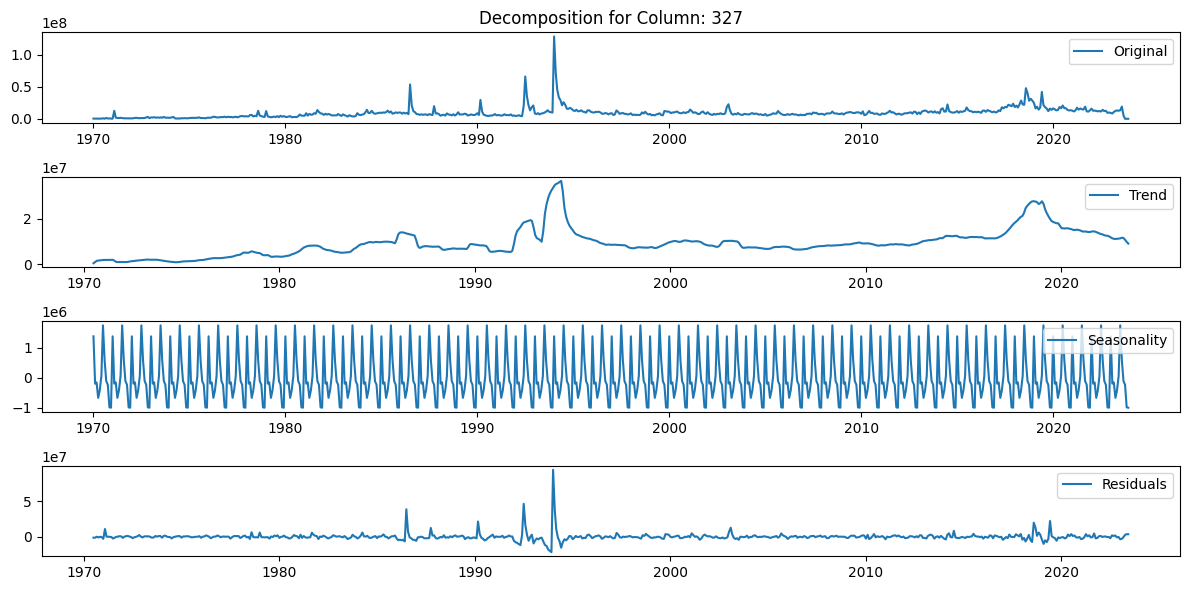

ADF Statistic for 57: -2.79
p-value for 57: 0.06
---
KPSS Statistic for 57: 1.57
p-value for 57: 0.01
---


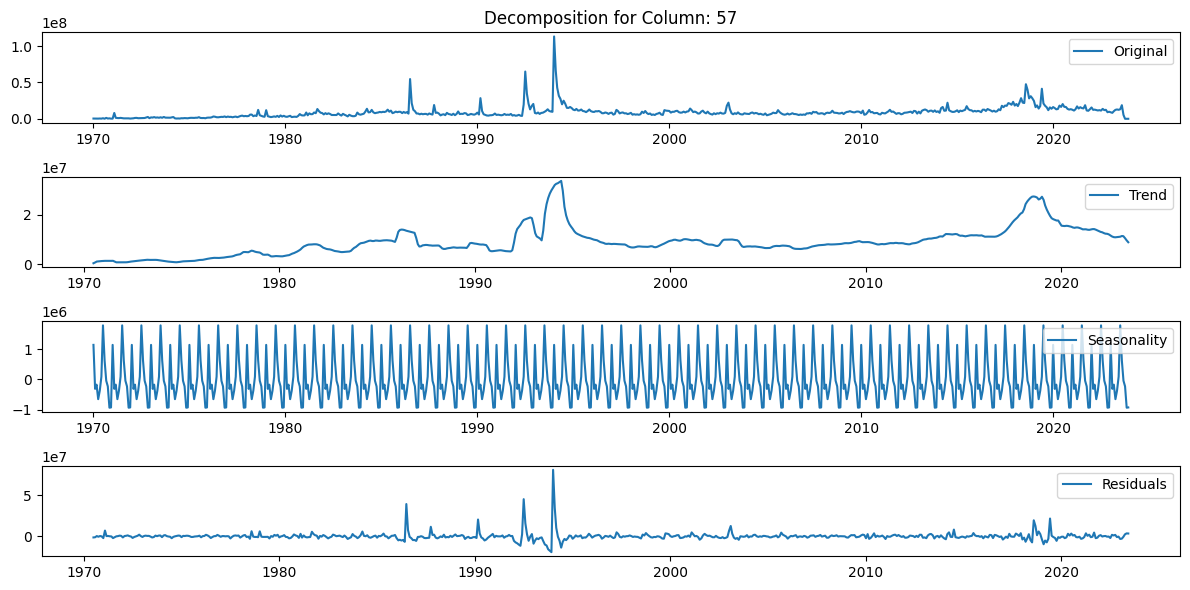

ADF Statistic for 12: -2.79
p-value for 12: 0.06
---
KPSS Statistic for 12: 1.57
p-value for 12: 0.01
---


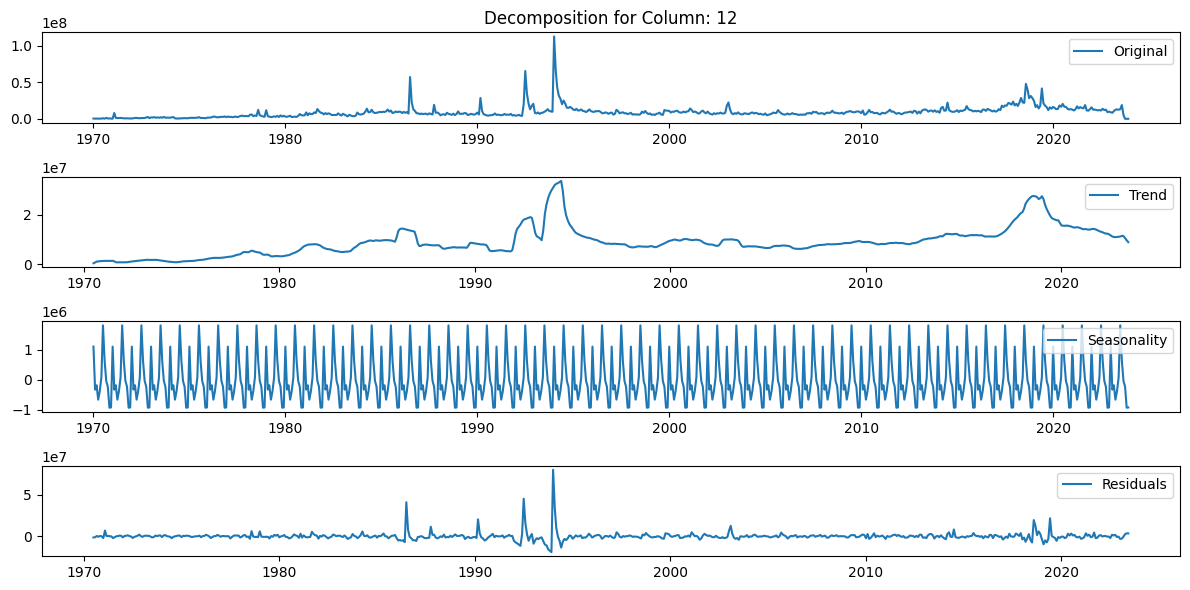

ADF Statistic for 379: -2.64
p-value for 379: 0.08
---
KPSS Statistic for 379: 1.57
p-value for 379: 0.01
---


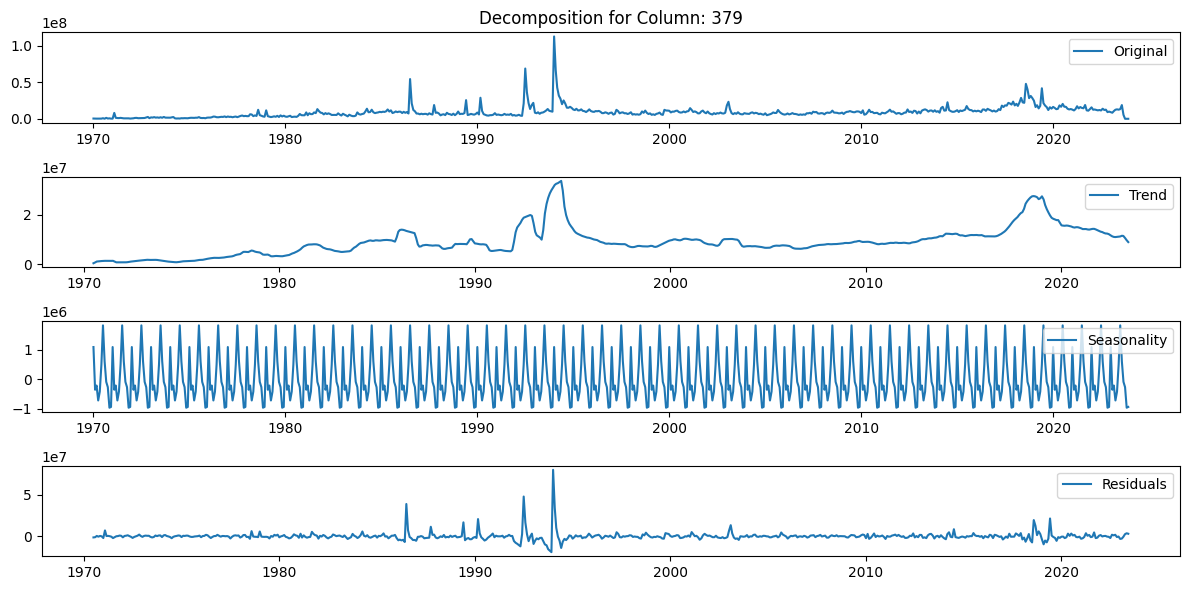

ADF Statistic for 140: -2.91
p-value for 140: 0.04
---
KPSS Statistic for 140: 1.50
p-value for 140: 0.01
---


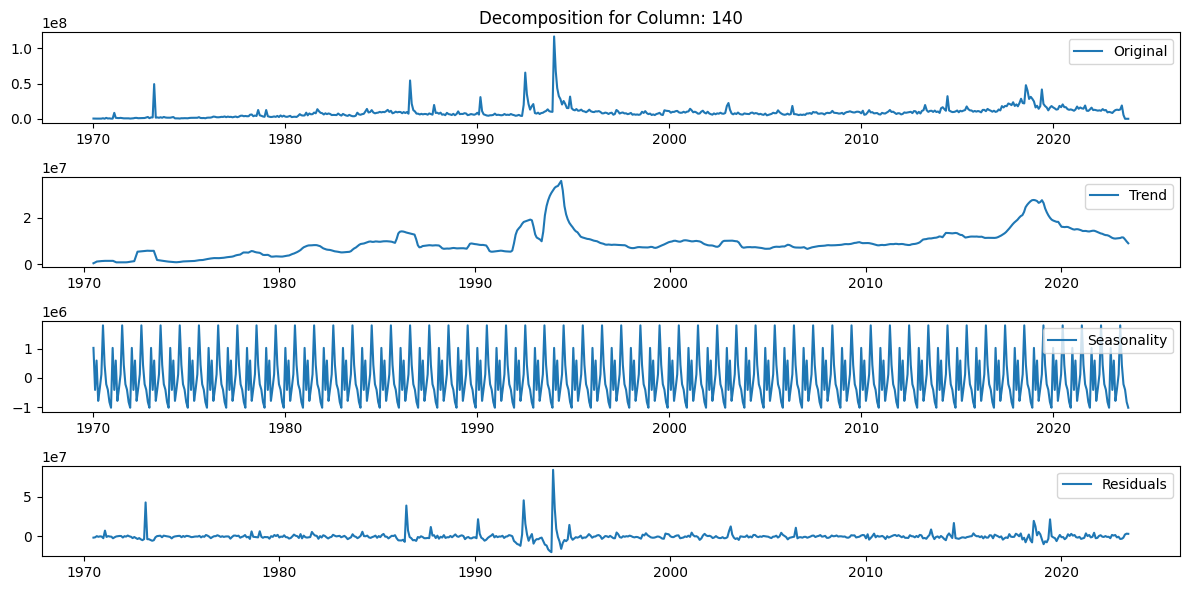

ADF Statistic for 125: -2.68
p-value for 125: 0.08
---
KPSS Statistic for 125: 1.55
p-value for 125: 0.01
---


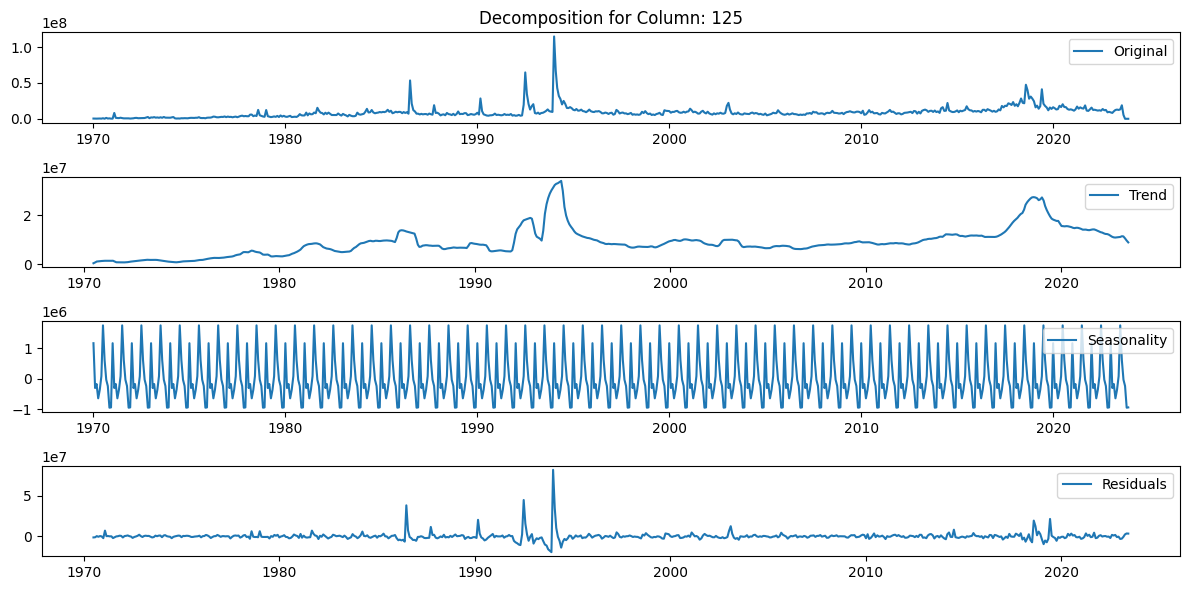

ADF Statistic for 114: -12.11
p-value for 114: 0.00
---
KPSS Statistic for 114: 1.34
p-value for 114: 0.01
---


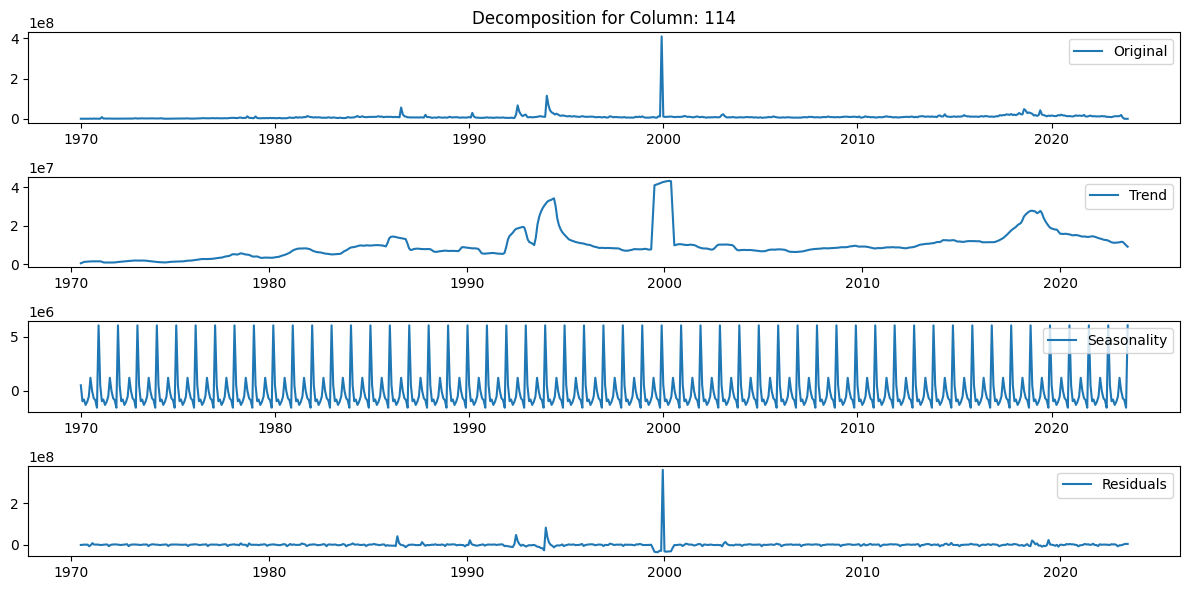

ADF Statistic for 71: -2.81
p-value for 71: 0.06
---
KPSS Statistic for 71: 1.48
p-value for 71: 0.01
---


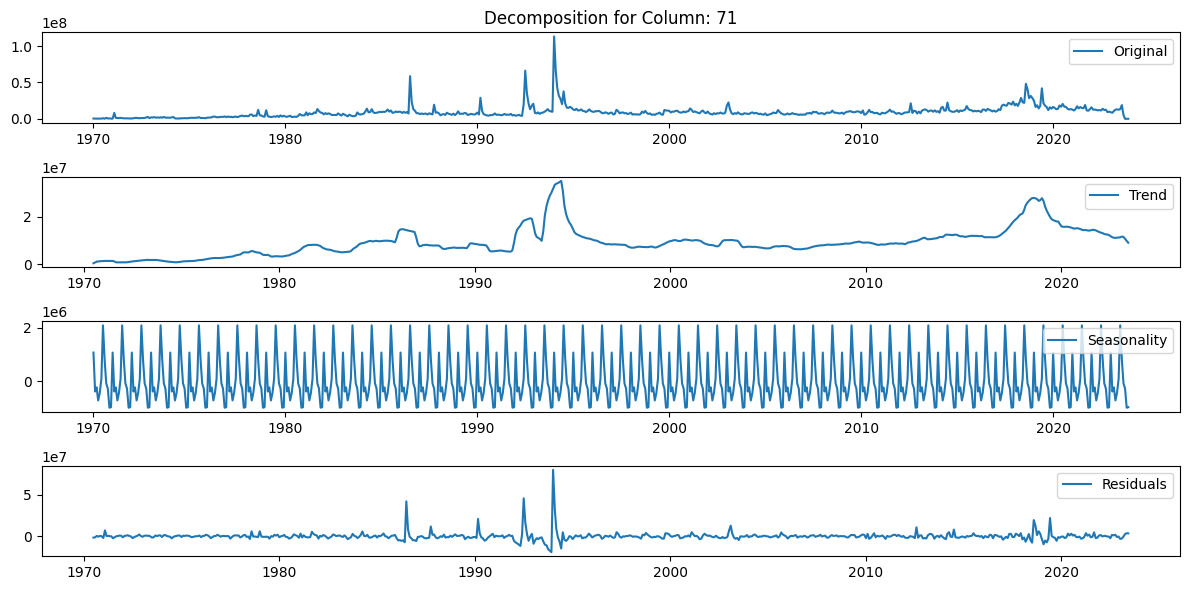

ADF Statistic for 377: -2.81
p-value for 377: 0.06
---
KPSS Statistic for 377: 1.56
p-value for 377: 0.01
---


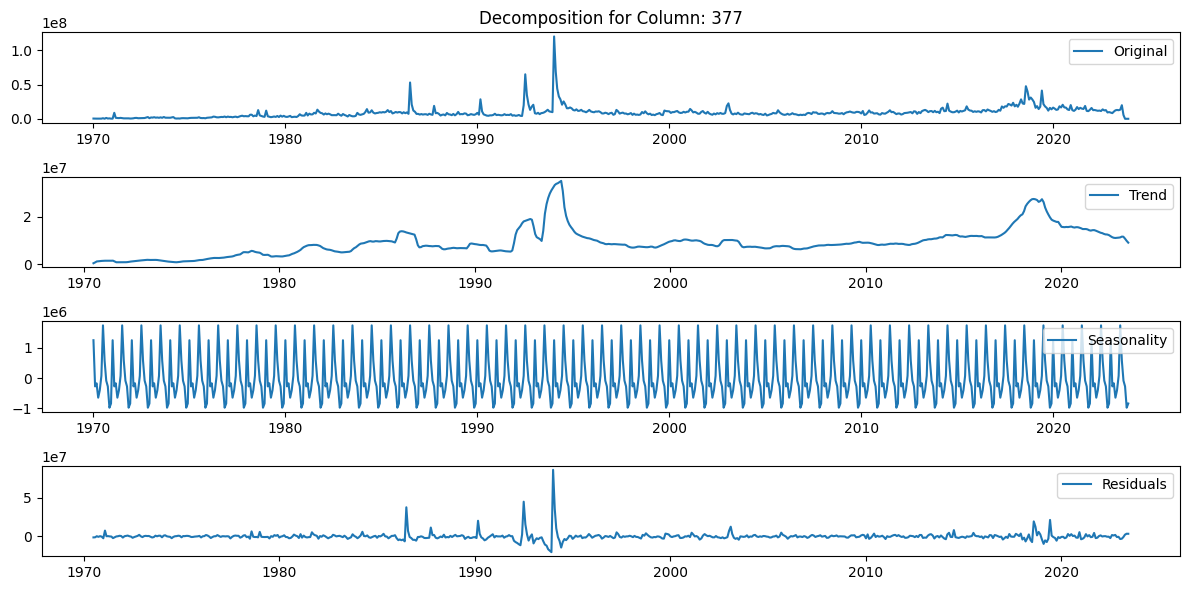

ADF Statistic for 52: -2.79
p-value for 52: 0.06
---
KPSS Statistic for 52: 1.56
p-value for 52: 0.01
---


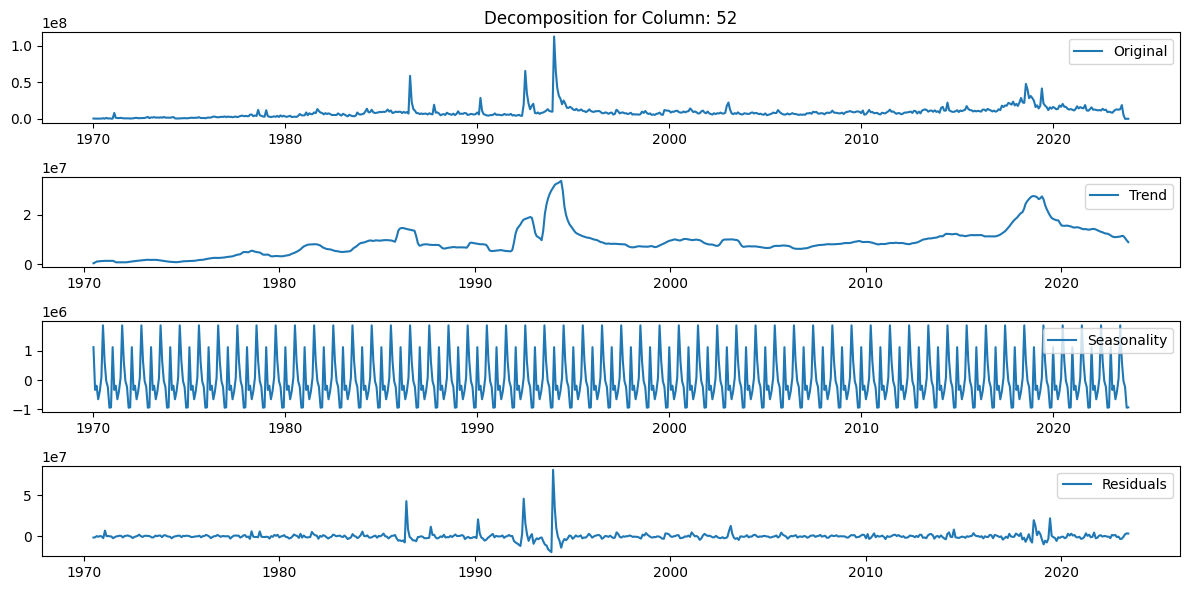

In [15]:
# loop over the decomped column and visualze the different plot for trend, residuals and seasonality
# Perform time series decomposition for the selected columns


# add in function for Augmented Dickey-Fuller test
def adf_test(series, column_name):
    result = adfuller(series)
    print(f'ADF Statistic for {column_name}: {result[0]:.2f}')
    print(f'p-value for {column_name}: {result[1]:.2f}')
    print('---')
# Add a function for the kpss test as well
def kpss_test(series, column_name):
    result = kpss(series)
    print(f'KPSS Statistic for {column_name}: {result[0]:.2f}')
    print(f'p-value for {column_name}: {result[1]:.2f}')
    print('---')



for column in columns_to_decompose:
    decomposition = sm.tsa.seasonal_decompose(set_index_df[column], model='additive')

    # Perform ADF Test and KPSS Test
    adf_test(set_index_df[column], column)
    kpss_test(set_index_df[column], column)

    # Plot the decomposed components
    plt.figure(figsize=(12, 6))
    plt.subplot(411)
    plt.plot(set_index_df[column], label='Original')
    plt.legend(loc='best')
    plt.title(f'Decomposition for Column: {column}')

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='best')

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonality')
    plt.legend(loc='best')

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuals')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

These charts provide insights into the underlying patterns in the earthquake data through time series decomposition. It appears that there is a seasonal component, as evidenced by noticeable spikes presumably occurring in the summer months, while declines are observed around the start of the new year, suggesting wintertime (assuming typical seasonal patterns and without explicit month labels on the x-axis, this inference might require further validation).

The trend component illustrates the general direction of the data over time, derived from the difference between the original data and the seasonal plus residual components. In the current trend plot, the y-axis represents the trend values, and the x-axis represents time (likely in years). The trend line's slope provides insight into whether the data is increasing or decreasing over time.

The residual component is the difference between the original data and the fitted values (seasonal + trend components). In the current residual plot, the x-axis represents time, and the y-axis represents the residual values. This plot highlights the variation in the data that isn't explained by the trend and seasonal components, portraying the 'leftover' variability in the data.

The augmented Dickey Fuller test and the Kwiatkowski-Phillips-Schmidt-Shin test were also incorported to the above analysis to assist in determining if we can accept or reject the null hypothesis. The null-hypothesis is if our data is statinary or not. Given that our p-values are less than .05 we can reject the null hypthesesis for both the ADF but accept the null hypthoesis for KPSS. We need a beter visualization to determine if this is stationary or not.

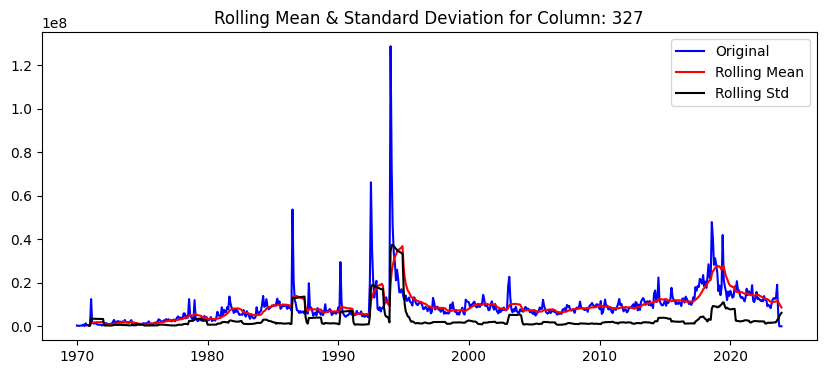

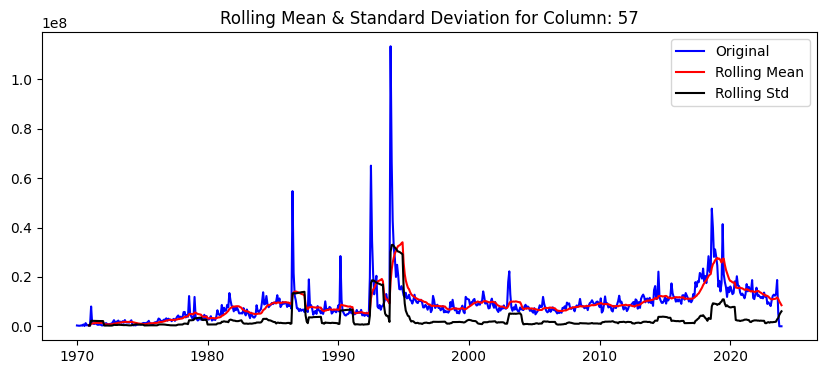

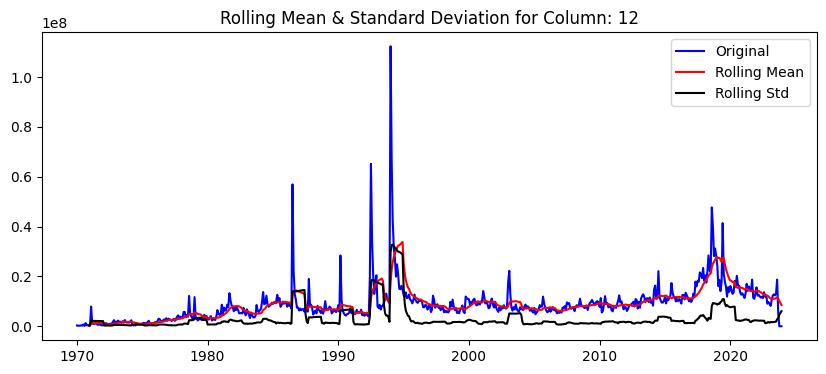

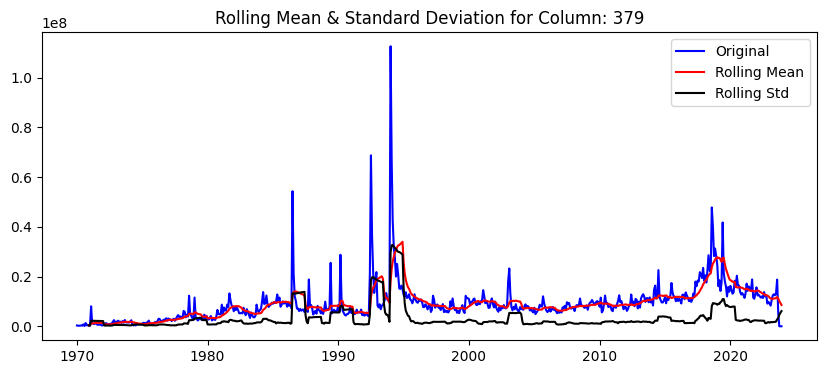

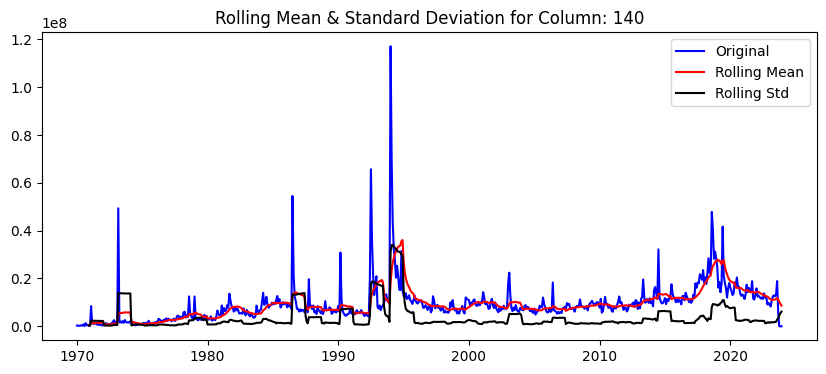

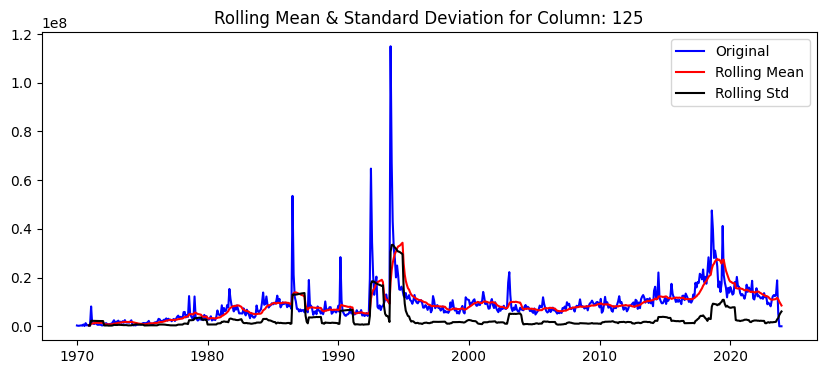

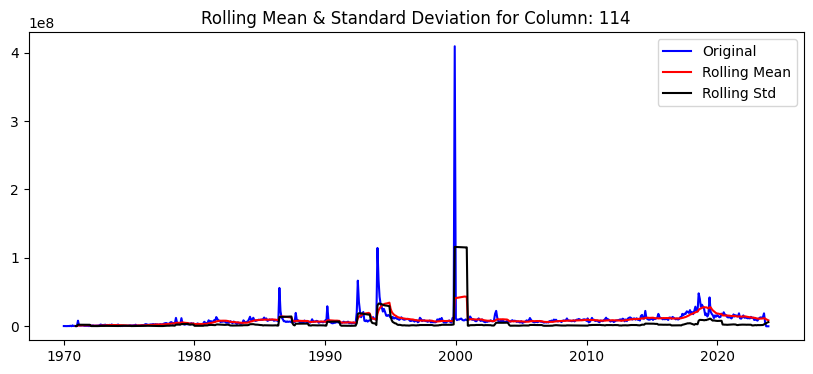

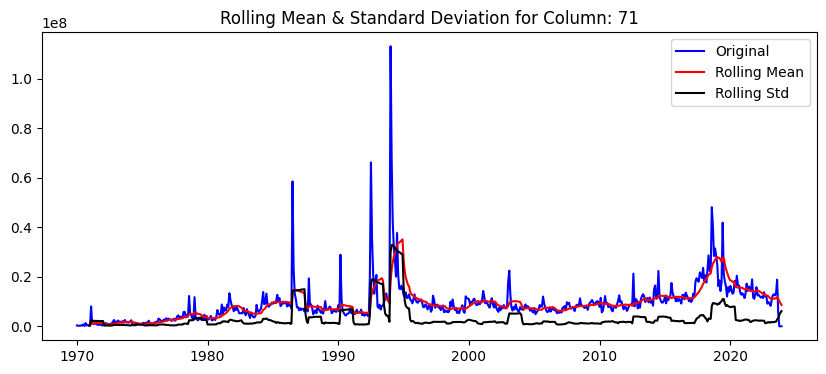

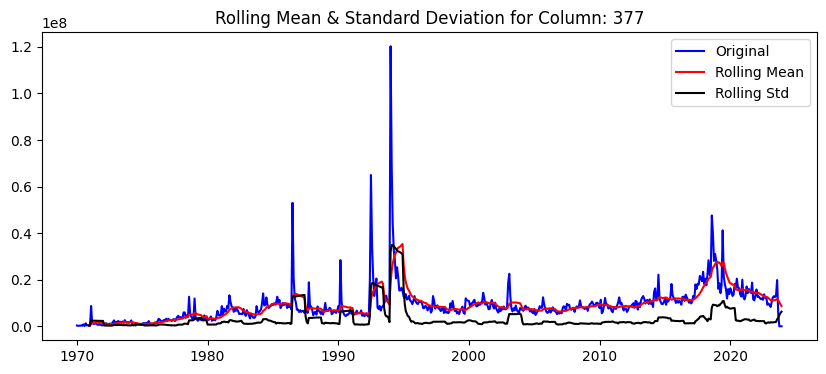

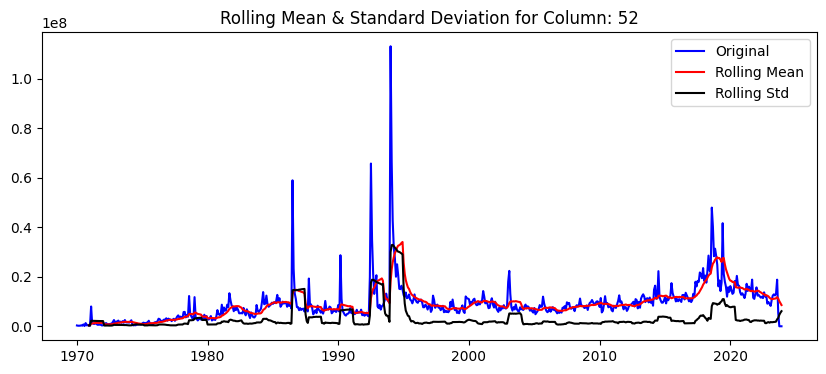

In [16]:
for column in columns_to_decompose:
    plt.figure(figsize=(10, 4))
    rolling_mean = set_index_df[column].rolling(window=12).mean()
    rolling_std = set_index_df[column].rolling(window=12).std()
    plt.plot(set_index_df[column], color='blue',label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for Column: {column}')
    plt.show()

From the visualization, the data points are collected at regular intervals along the x-axis, ensuring a consistent time series. However, the key aspect of stationarity lies in the statistical properties of the series. Although there are spikes, which might represent anomalies, the general trend does not exhibit an obvious upward or downward trend, and the variance appears to be relatively constant over time. Given that the ADF and KPSS tests countered eachother this graph representation inidciates to me that the data is stationary.

# Data Prep for modeling



since the data is in the same measurement, scaling may not be needed however, after the intial build of a model we can compare how the sacled data does against the non scaled data

In [17]:
# reset the index to set_index and the filter out the dates that have not happened yet, anything less thant october 1st
reset_date = set_index_df.reset_index()
filtered_data = reset_date[reset_date['date'] < '2023-10-01']
filtered_data.set_index('date', inplace = True)

In [18]:
filtered_data.tail()

0             1             2             3    \
date                                                                 
2023-05-01  1.295133e+07  1.294601e+07  1.293764e+07  1.292868e+07   
2023-06-01  1.245500e+07  1.245209e+07  1.244599e+07  1.243812e+07   
2023-07-01  1.319728e+07  1.319441e+07  1.318975e+07  1.318528e+07   
2023-08-01  1.870089e+07  1.870571e+07  1.870992e+07  1.871578e+07   
2023-09-01  5.361820e+06  5.360052e+06  5.357183e+06  5.353730e+06   

                     4             5             6             7    \
date                                                                 
2023-05-01  1.292327e+07  1.297673e+07  1.292243e+07  1.288675e+07   
2023-06-01  1.242947e+07  1.242061e+07  1.241182e+07  1.240326e+07   
2023-07-01  1.318665e+07  1.339377e+07  1.319100e+07  1.327230e+07   
2023-08-01  1.872804e+07  1.874681e+07  1.875831e+07  1.899694e+07   
2023-09-01  5.350041e+06  5.346319e+06  5.342670e+06  5.339132e+06   

                     8             9    ...           431           432  \
date                                    ...                               
2023-05-01  1.286811e+07  1.285414e+07  ...  1.287256e+07  1.291138e+07   
2023-06-01  1.239503e+07  1.238724e+07  ...  1.245350e+07  1.248759e+07   
2023-07-01  1.315832e+07  1.313592e+07  ...  1.317878e+07  1.320010e+07   
2023-08-01  1.893520e+07  1.970157e+07  ...  1.888274e+07  1.894730e+07   
2023-09-01  5.335680e+06  5.332233e+06  ...  5.343838e+06  5.349055e+06   

                     433           434           435           436  \
date                                                                 
2023-05-01  1.291867e+07  1.290676e+07  1.294960e+07  1.290056e+07   
2023-06-01  1.259606e+07  1.259751e+07  1.336813e+07  1.263806e+07   
2023-07-01  1.327615e+07  1.330820e+07  1.374461e+07  1.333703e+07   
2023-08-01  1.908524e+07  1.901665e+07  1.902740e+07  1.906607e+07   
2023-09-01  5.344985e+06  5.345196e+06  5.348178e+06  5.352850e+06   

                     437           438           439           440  
date                                                                
2023-05-01  1.290935e+07  1.297274e+07  1.449374e+07  1.304076e+07  
2023-06-01  1.251133e+07  1.250449e+07  1.257219e+07  1.250866e+07  
2023-07-01  1.320433e+07  1.318031e+07  1.318689e+07  1.325853e+07  
2023-08-01  1.911236e+07  1.914856e+07  1.922454e+07  1.923048e+07  
2023-09-01  5.358410e+06  5.366393e+06  5.380113e+06  5.404569e+06  

[5 rows x 441 columns]

In [19]:
# scale the data
scaler = StandardScaler()
new_df = filtered_data.reset_index()
date_column = new_df['date']
data_without_date = new_df.drop(columns = 'date')
# scale the data
scaled_data = scaler.fit_transform(data_without_date)
scaled_data_df = pd.DataFrame(scaled_data, columns = data_without_date.columns)
scaled_data_with_date = pd.concat([date_column.reset_index(drop=True), scaled_data_df], axis =1)
new_df.set_index('date', inplace = True)

In [20]:
new_df.head()

0              1              2              3    \
date                                                                     
1970-01-01  321067.119801  321135.048331  321124.857167  321042.681773   
1970-02-01  217466.025395  217858.321949  218220.005878  218560.875641   
1970-03-01  216460.713365  217512.038970  218890.530045  220840.334270   
1970-04-01  235927.791432  236179.903510  236428.142760  236672.125843   
1970-05-01  372851.336456  373378.739201  373879.680493  374351.298586   

                      4              5              6              7    \
date                                                                     
1970-01-01  320896.868751  320696.998421  320453.023487  320174.622771   
1970-02-01  218891.321623  219219.660568  219551.121548  219889.987552   
1970-03-01  223822.556741  228579.253880  234618.200632  235199.597137   
1970-04-01  236912.186203  237149.416781  237385.635669  237623.294830   
1970-05-01  374789.570733  375188.343701  375538.379452  375826.518149   

                      8              9    ...            431            432  \
date                                      ...                                 
1970-01-01  319870.785259  319549.580501  ...  330375.343979  331692.410816   
1970-02-01  220246.145972  220647.076863  ...  212851.584622  212614.553994   
1970-03-01  229620.977354  224987.729336  ...  217423.033571  218176.468137   
1970-04-01  237865.367904  238115.256669  ...  247889.310549  249606.810727   
1970-05-01  376035.254883  376143.441675  ...  382184.094257  383575.911711   

                      433            434            435            436  \
date                                                                     
1970-01-01  333540.318673  335854.239982  338056.517228  338781.130565   
1970-02-01  212357.237275  212083.543453  211797.622578  211503.571619   
1970-03-01  219029.472636  219920.430917  220664.378128  220975.150370   
1970-04-01  251683.551875  254083.487224  256490.601006  258090.768979   
1970-05-01  385886.419992  390142.146805  399931.493767  425244.427052   

                      437            438            439            440  
date                                                                    
1970-01-01  337206.412599  334433.569361  331723.455688  329467.781893  
1970-02-01  211205.199775  210905.873823  210608.441399  210315.216979  
1970-03-01  220697.452192  219992.508723  219151.974410  218364.029661  
1970-04-01  257990.598175  256308.414184  254011.569737  251827.995821  
1970-05-01  413800.324487  393133.309299  384923.949978  380586.802480  

[5 rows x 441 columns]

In [21]:
# Dictionary to hold forecasters
forecasters = {}

for column in new_df.columns:
    # Initialize forecaster
    f = Forecaster(
        y=new_df[column].values,
        current_dates=new_df.index.strftime('%Y-%m-%d').tolist(),
        require_future_dates=True,
        future_dates=None,  # Replace with an array of future dates if you have them
        test_length=0,
        cis=False,
        metrics=['rmse', 'mape', 'mae', 'r2']
    )

    # Save forecaster to dictionary
    forecasters[column] = f


PACF for column: 0


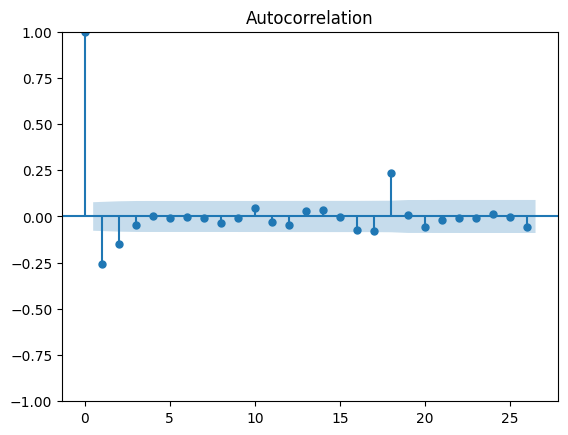

PACF for column: 1


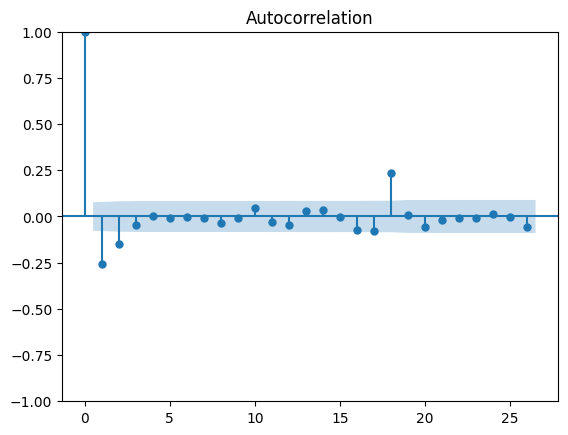

PACF for column: 2


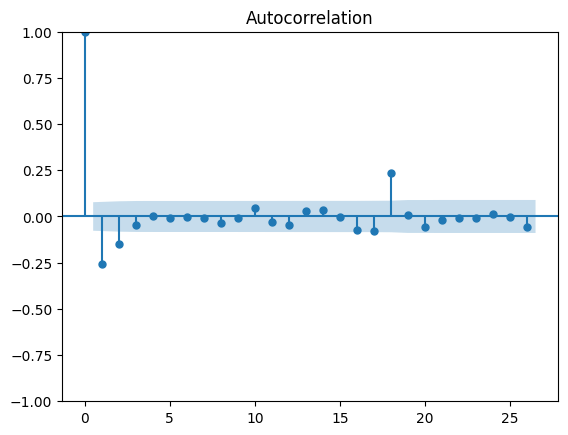

PACF for column: 3


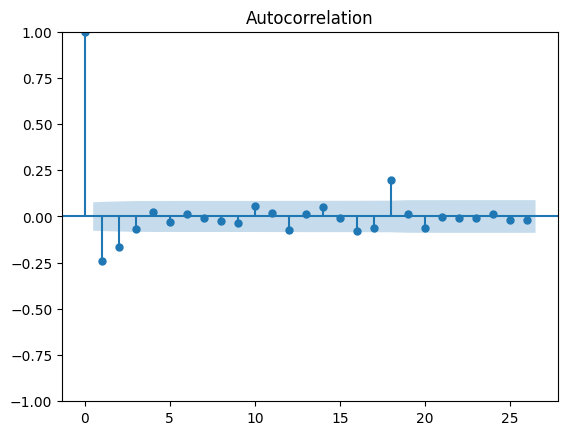

PACF for column: 4


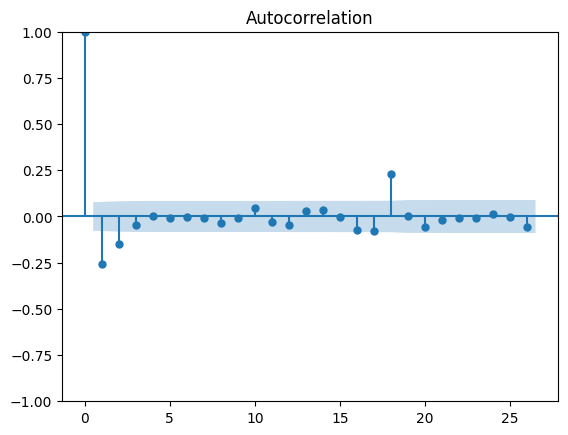

PACF for column: 5


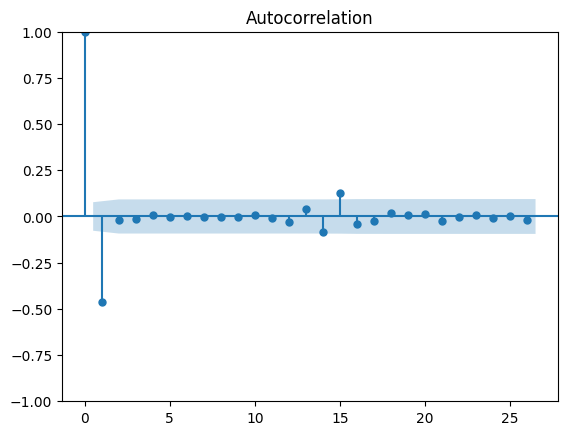

PACF for column: 6


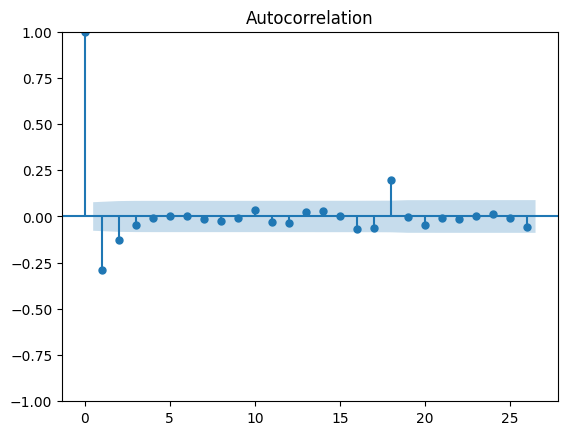

PACF for column: 7


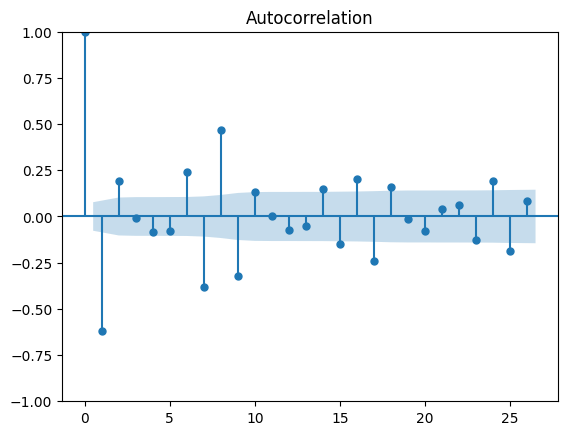

PACF for column: 8


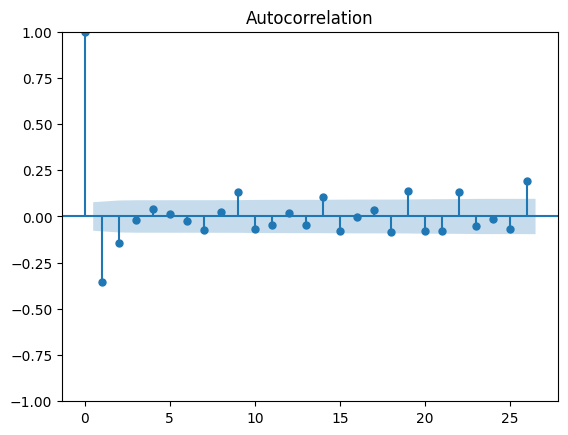

PACF for column: 9


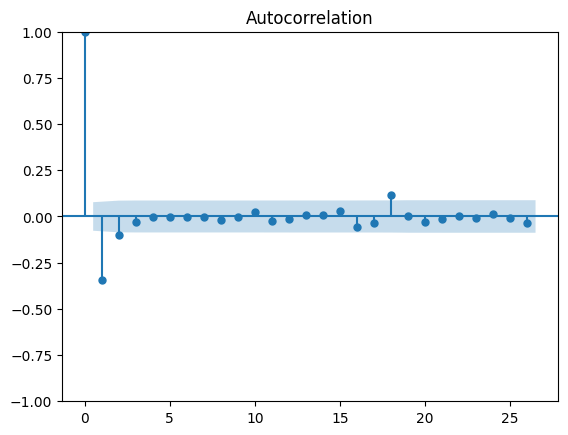

In [22]:
for i, (column, forecaster) in enumerate(forecasters.items()):
    if i >= 10:
        break  # Exit the loop after 10 iterations
    print(f'PACF for column: {column}')  # Output label to know which column is being plotted
    forecaster.plot_acf(diffy=True, lags=26)
    plt.show()

PACF for column: 0


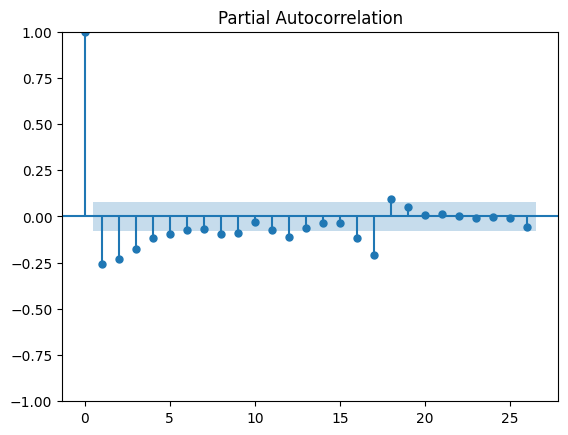

PACF for column: 1


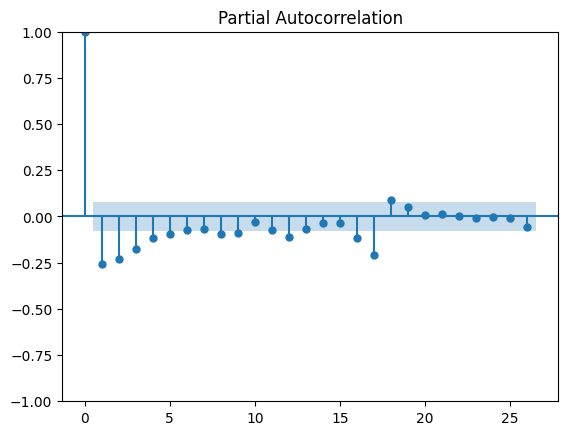

PACF for column: 2


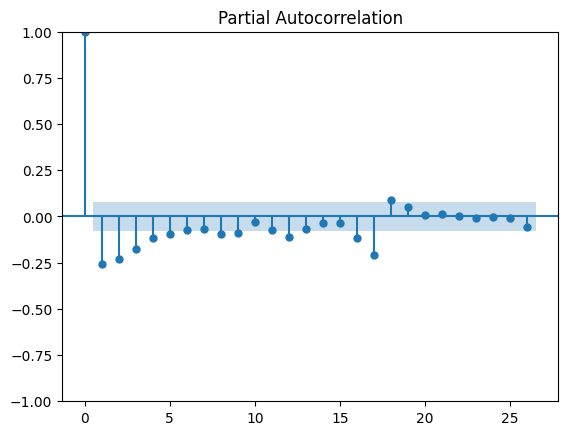

PACF for column: 3


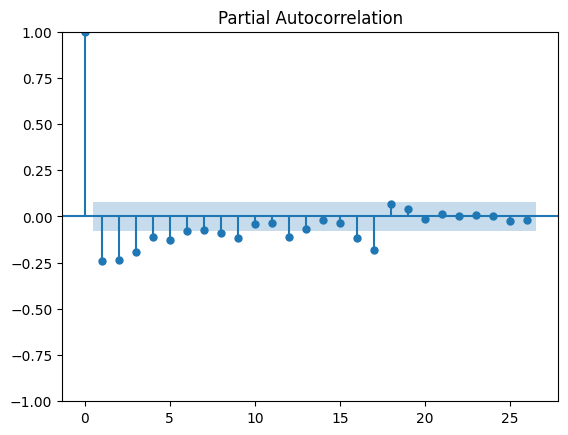

PACF for column: 4


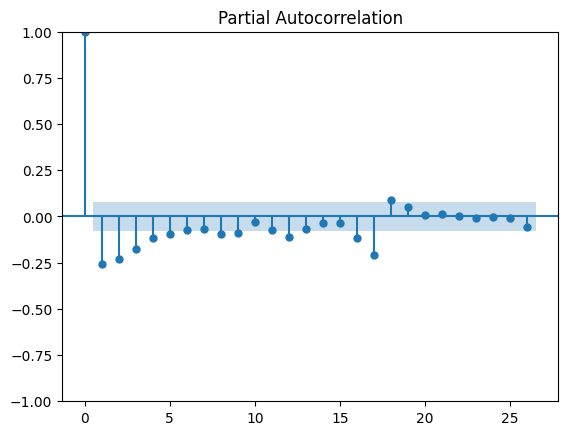

PACF for column: 5


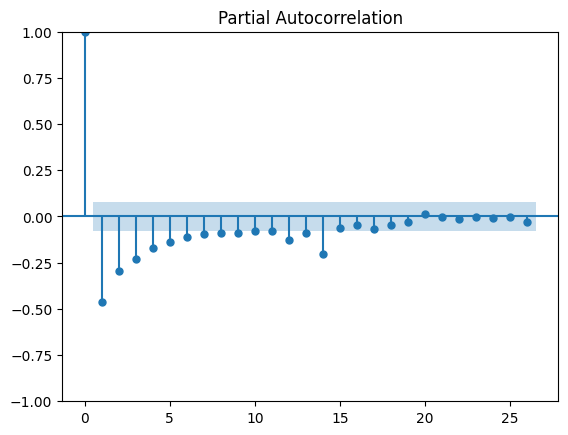

PACF for column: 6


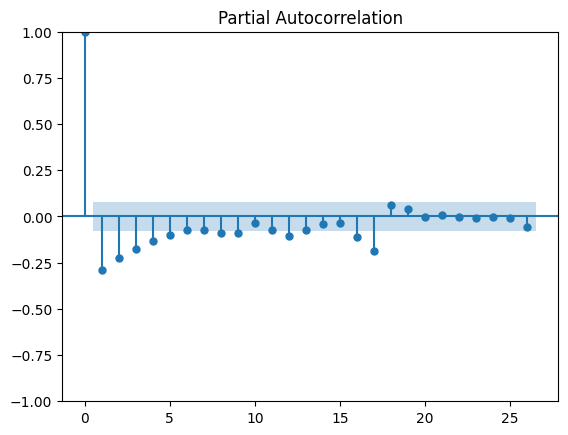

PACF for column: 7


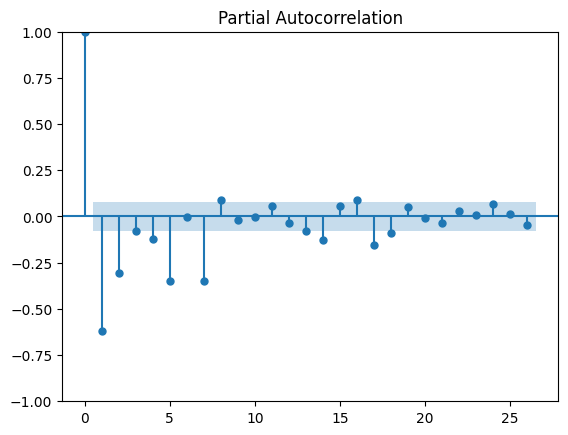

PACF for column: 8


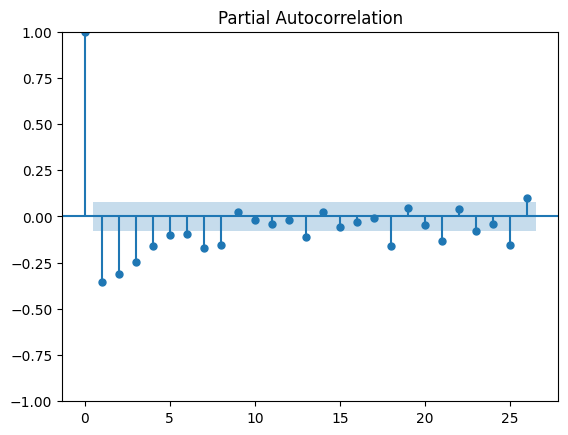

PACF for column: 9


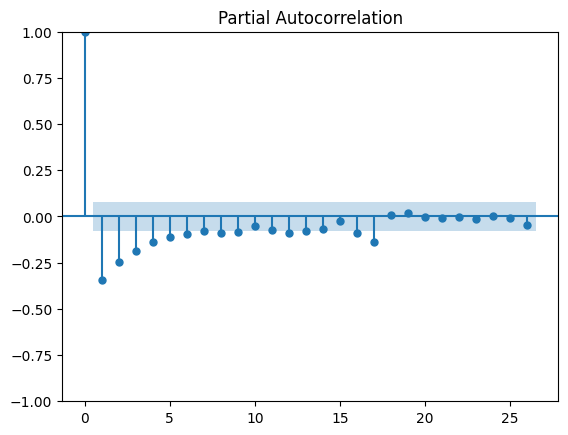

In [23]:
for i, (column, forecaster) in enumerate(forecasters.items()):
    if i >= 10:
        break  # Exit the loop after 10 iterations
    print(f'PACF for column: {column}')  # Output label to know which column is being plotted
    forecaster.plot_pacf(diffy=True, lags=26)
    plt.show()

Based on the above output for the first 10 columns we can see that as teh columns go from 1-10 that the autoregressive values starts to have a higher value as we go through the columns. we will set this to 6 based ont the charts above.

# Linear Regression Model

In [24]:
# Create lag features
df_lagged = new_df.shift().dropna()
for column in new_df.columns:
    df_lagged[f'{column}_lag1'] = new_df[column].shift()
df_lagged = df_lagged.dropna()
# Split data into training and testing sets
lr_train, lr_test = train_test_split(df_lagged, test_size=0.2, shuffle=False, random_state = 42)
# get the original columns back
original_columns = new_df.columns
lagged_columns = [f'{column}_lag1' for column in original_columns]
# setup training data
X_train = lr_train[lagged_columns]
y_train = lr_train[original_columns]
X_test = lr_test[lagged_columns]
y_test = lr_test[original_columns]
# Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)
# Convert predictions to DataFrame
predictions_df = pd.DataFrame(predictions, columns=original_columns, index=X_test.index)


# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

Mean Squared Error: 1.2958902929672484e-07
Root Mean Squared Error: 0.00035998476258964745


In [25]:
overall_mean = new_df.stack().mean()
print(f"Mean of the dataset as a whole: {overall_mean}")
print(f'Root Mean Squared Error: {rmse}')
# Calculate the percentage error
percentage_error = round((rmse / overall_mean) * 100,2)
print(f'Percentage Error of the Model {percentage_error}')

Mean of the dataset as a whole: 14800277.571721554
Root Mean Squared Error: 0.00035998476258964745
Percentage Error of the Model 0.0


<Figure size 1200x600 with 0 Axes>

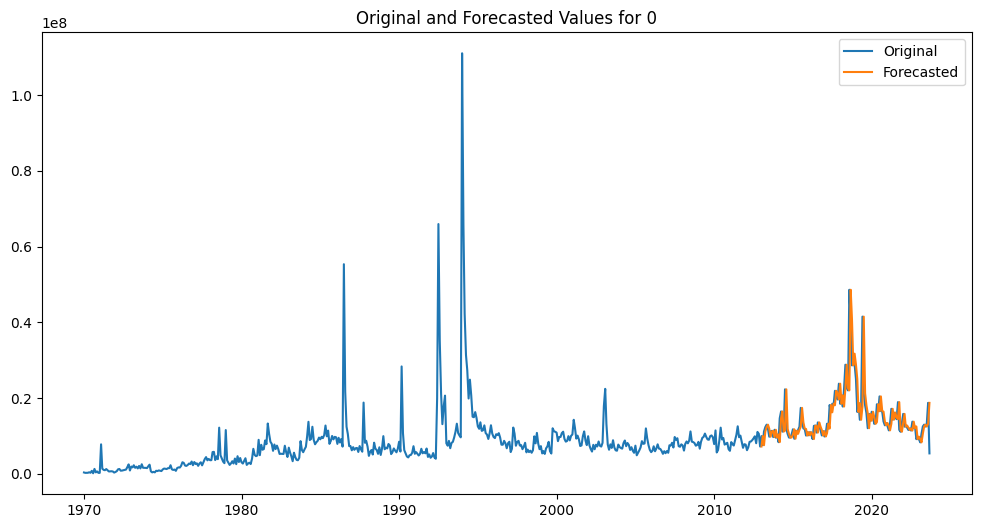

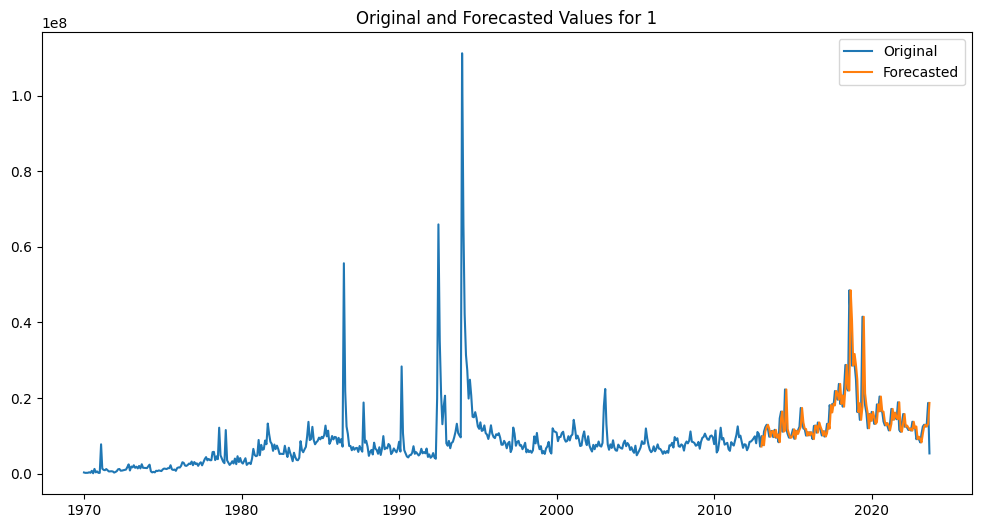

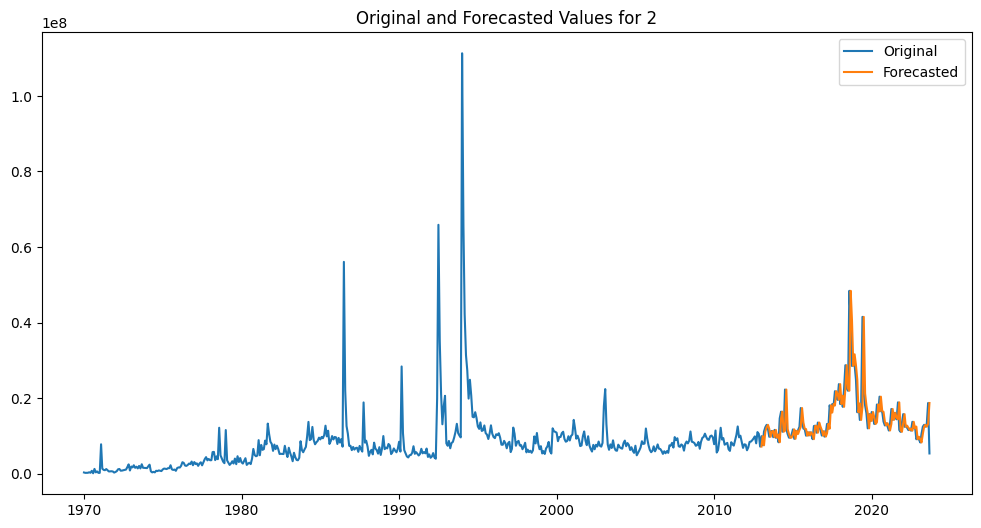

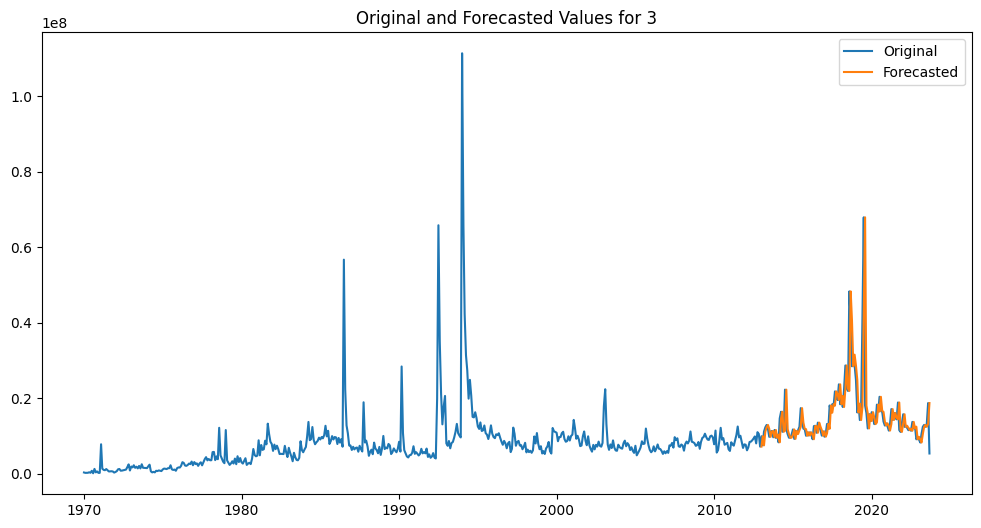

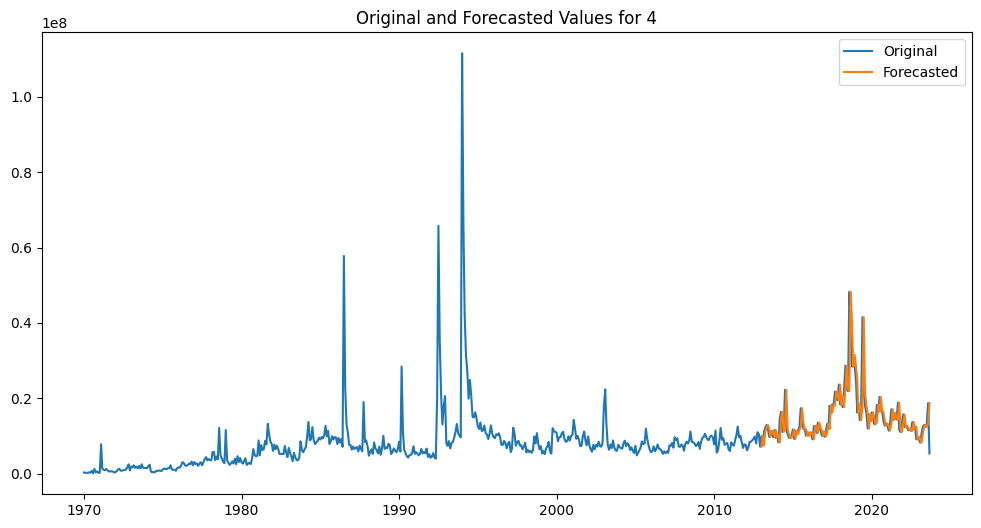

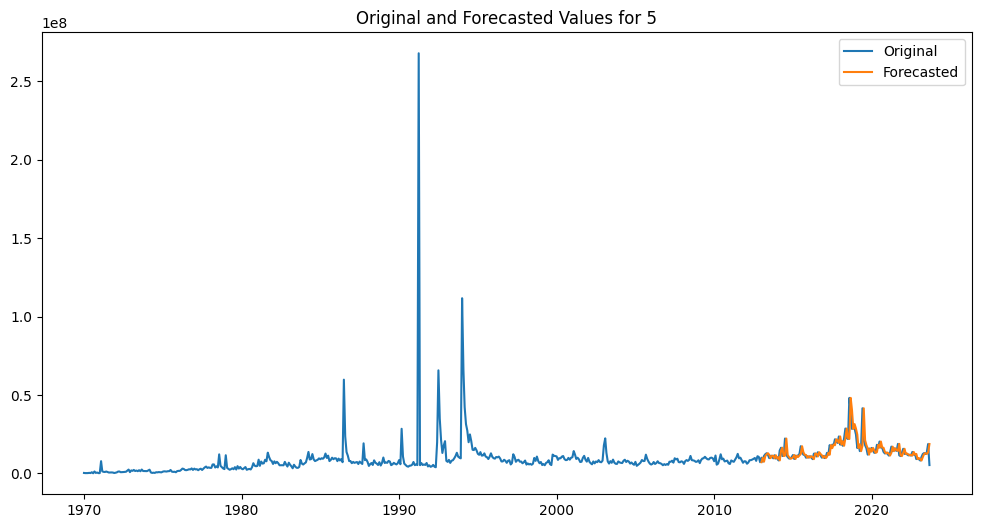

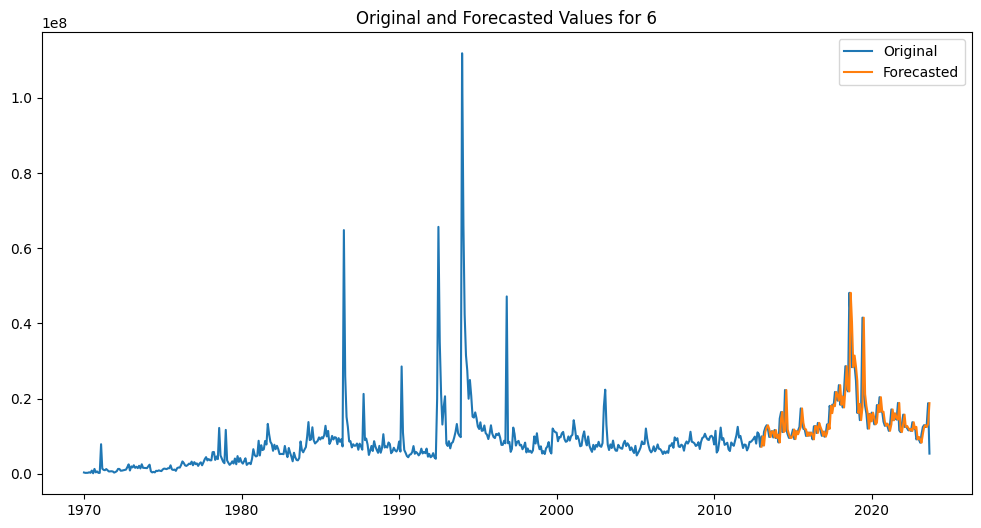

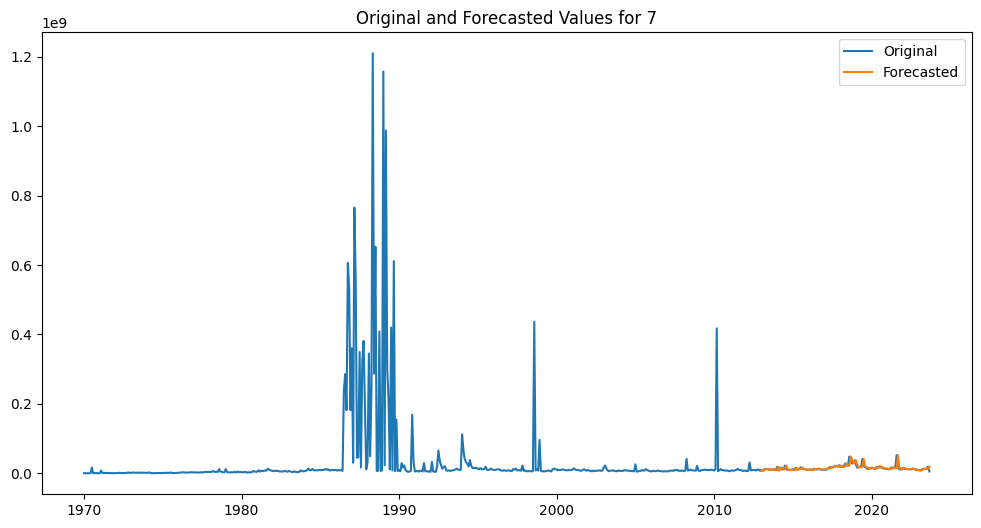

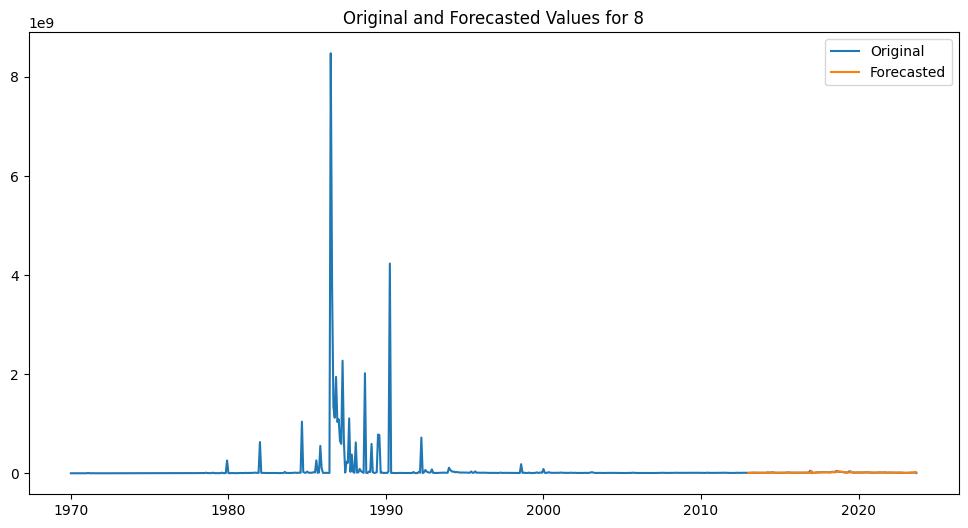

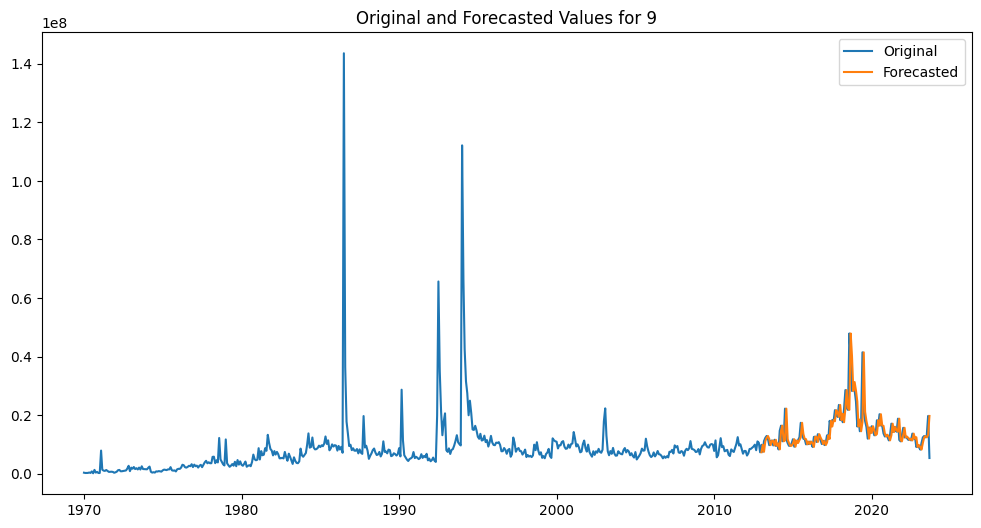

In [26]:
# Plotting the original data with the forecasted data
plt.figure(figsize=(12, 6))

# Assuming you want to plot the first column's original and forecasted values
# Adjust the column index accordingly to plot other columns
column_idx = 0
column_name = original_columns[column_idx]
for name in original_columns[:10]:
  plt.figure(figsize=(12, 6))
  plt.plot(new_df.index, new_df[name], label='Original')
  plt.plot(predictions_df.index, predictions_df[name], label='Forecasted')

  plt.legend()
  plt.title(f'Original and Forecasted Values for {name}')
  plt.show()

# redo the MLR model with the forecaster method

In [52]:
# Dictionary to hold forecasters
forecasters_2 = {}

for column in new_df.columns:
    # Initialize forecaster
    f_2 = Forecaster(
        y=new_df[column].values,
        current_dates=new_df.index.strftime('%Y-%m-%d').tolist(),
        future_dates=None,
        test_length = 0,
        validation_length = None,
        cis=False,
        metrics=['mape', 'mae', 'r2', 'rmse']
    )
    forecasters_2[column] =f_2



19/19 [==============================] - 0s 2ms/step


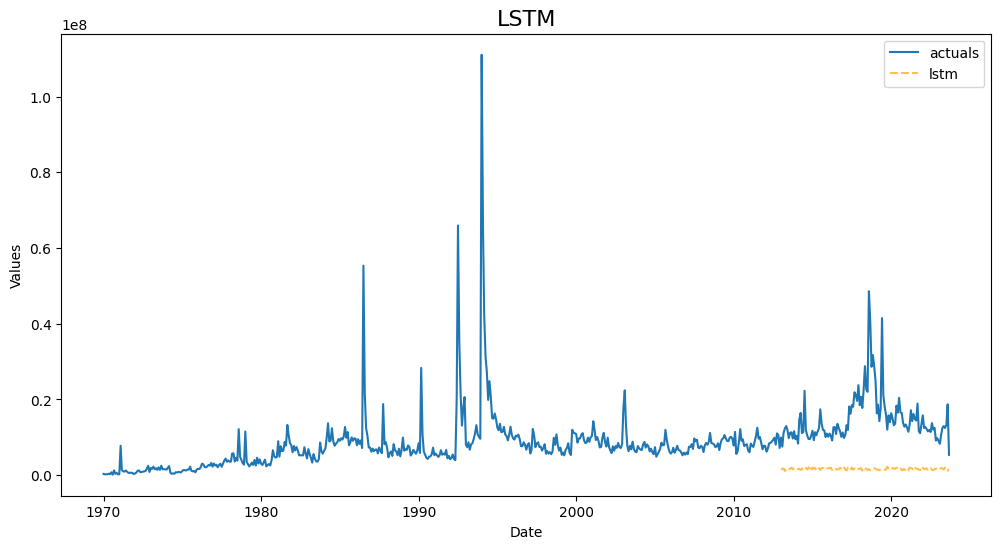

19/19 [==============================] - 0s 2ms/step


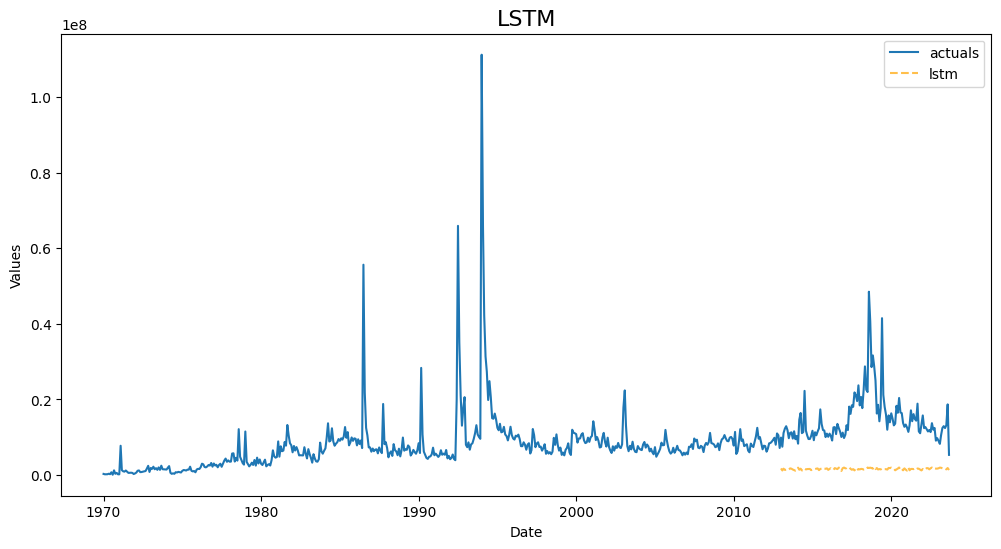

19/19 [==============================] - 0s 2ms/step


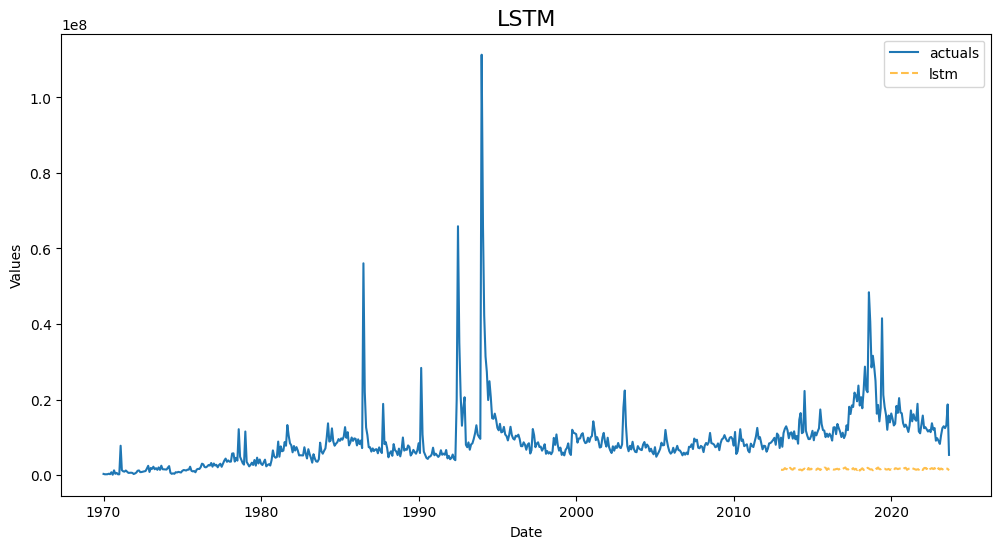

19/19 [==============================] - 0s 2ms/step


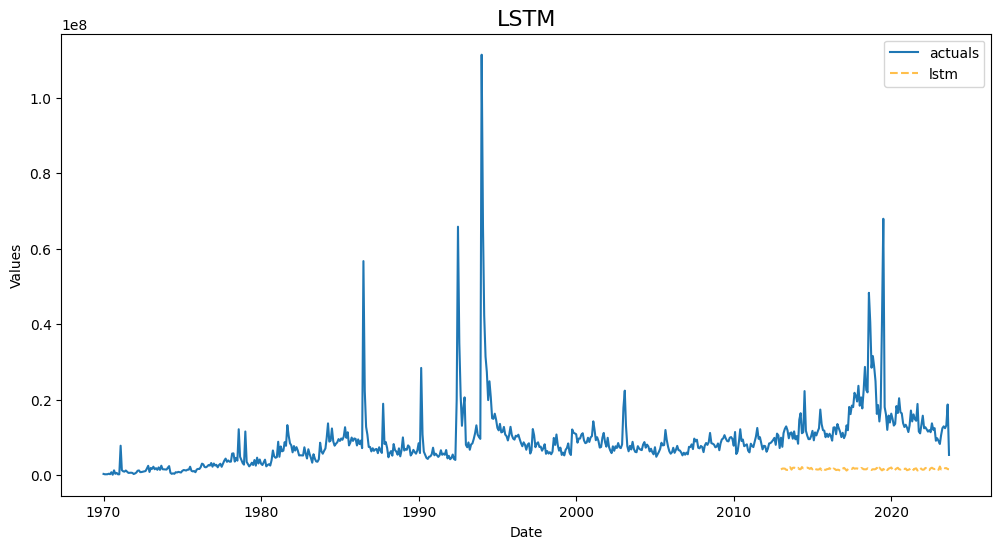

19/19 [==============================] - 0s 2ms/step


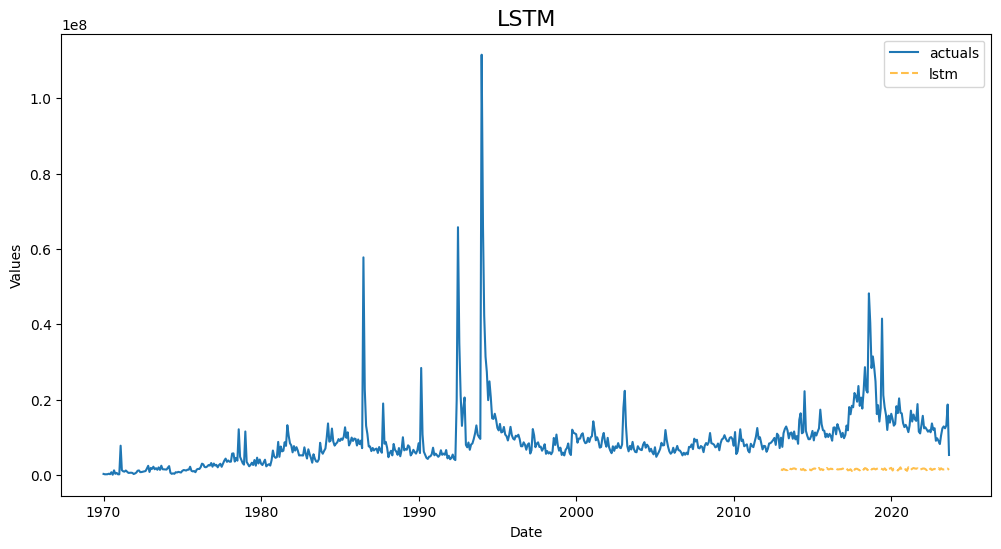

19/19 [==============================] - 0s 2ms/step


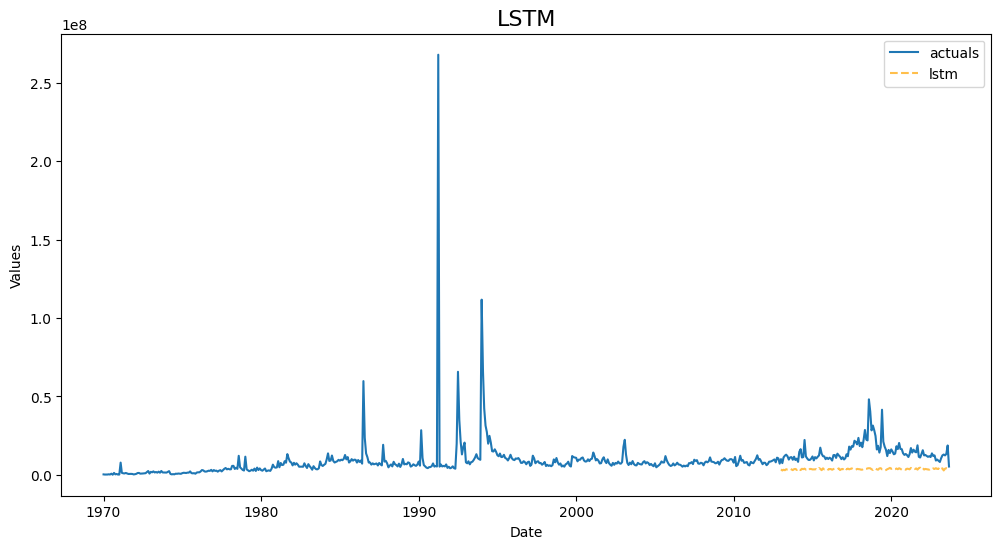

19/19 [==============================] - 0s 2ms/step


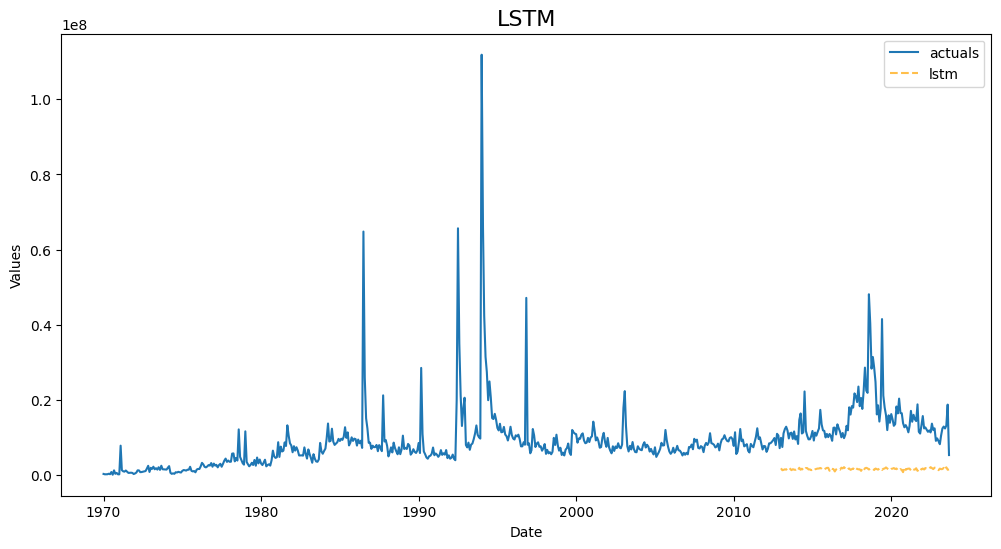

19/19 [==============================] - 0s 2ms/step


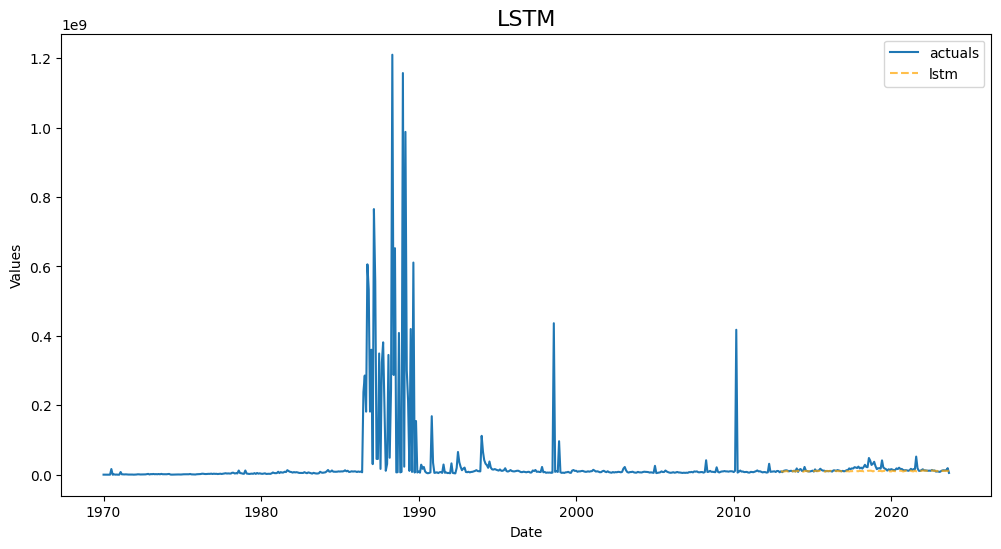

19/19 [==============================] - 0s 2ms/step


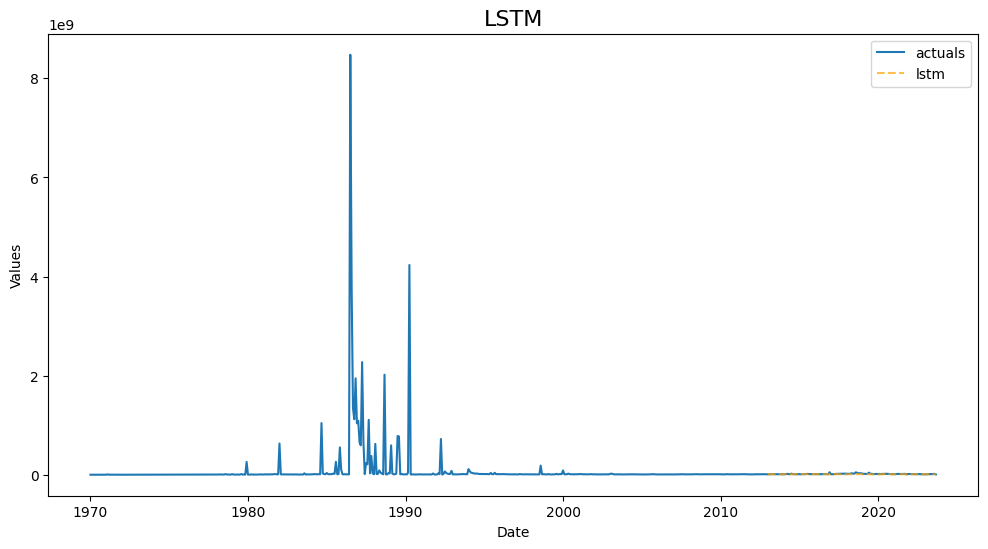

19/19 [==============================] - 0s 2ms/step


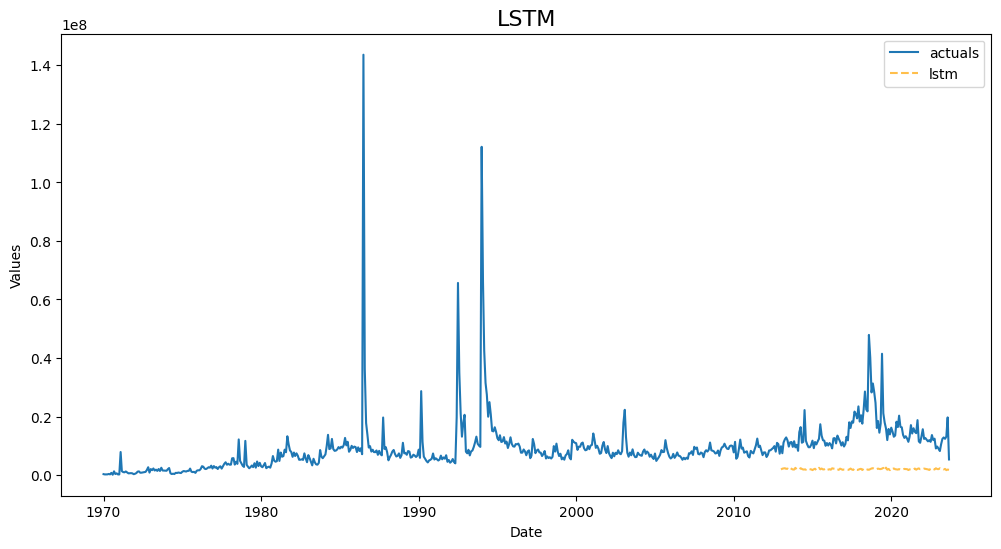

In [53]:
plot_counter = 0
for k, f in list(forecasters_2.items())[:10]:
  f.set_test_length(.2)
  f.generate_future_dates(60)
  f.add_ar_terms(6)
  f.add_seasonal_regressors('month', dummy=True)
  f.add_seasonal_regressors('year')
  f.add_time_trend()
  f.set_estimator('lstm')
  f.manual_forecast()
  f.plot_test_set(order_by='TestSetMAPE',models=['lstm'], ci = True)
  plt.title('LSTM',size=16)
  plt.show()

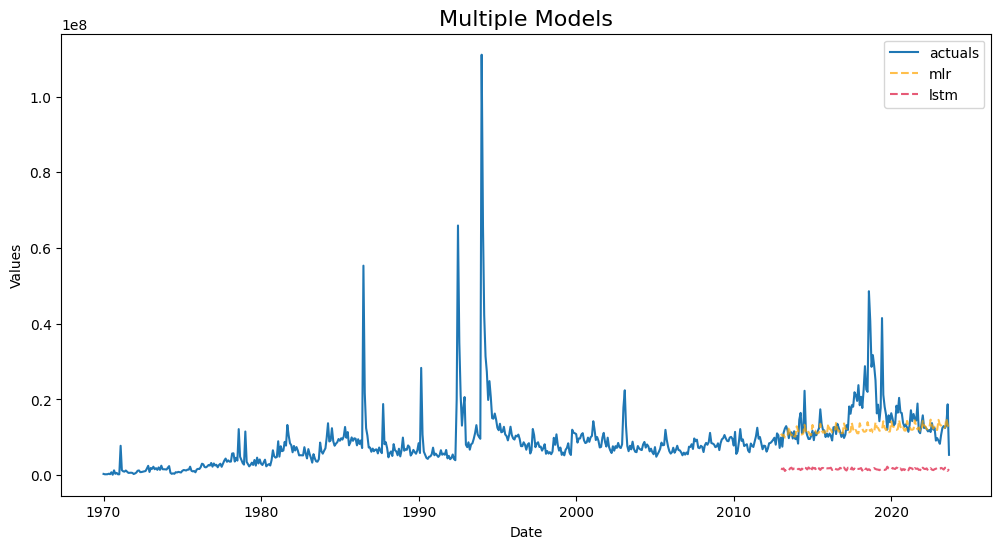

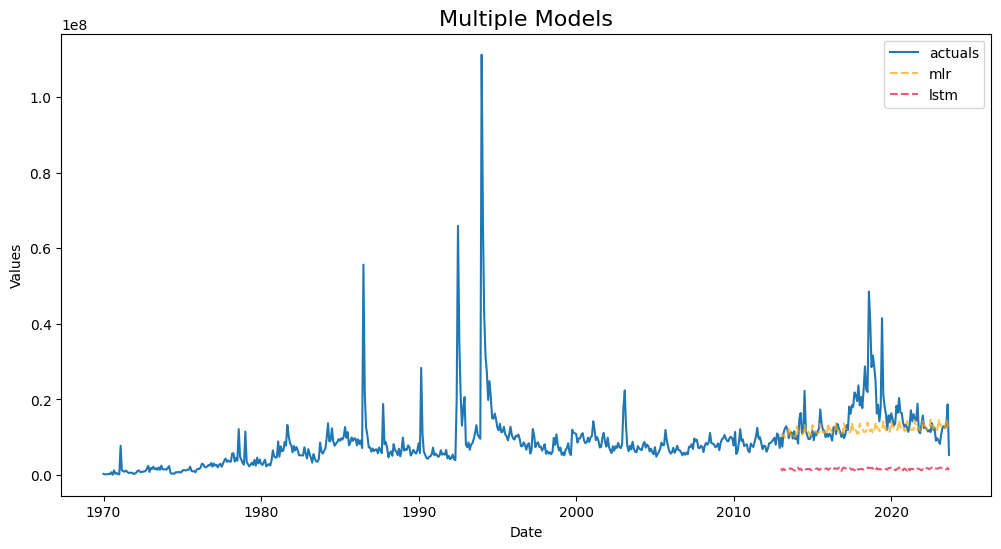

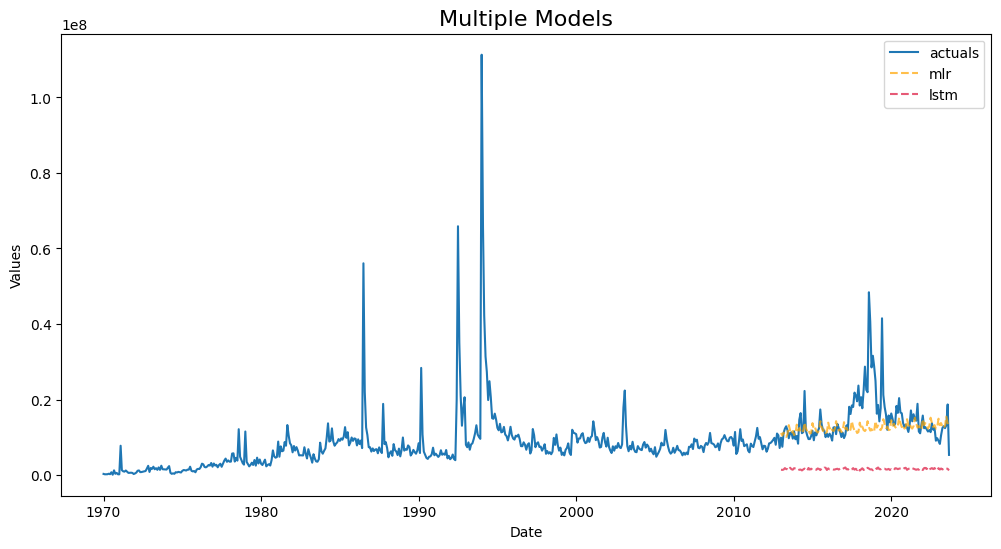

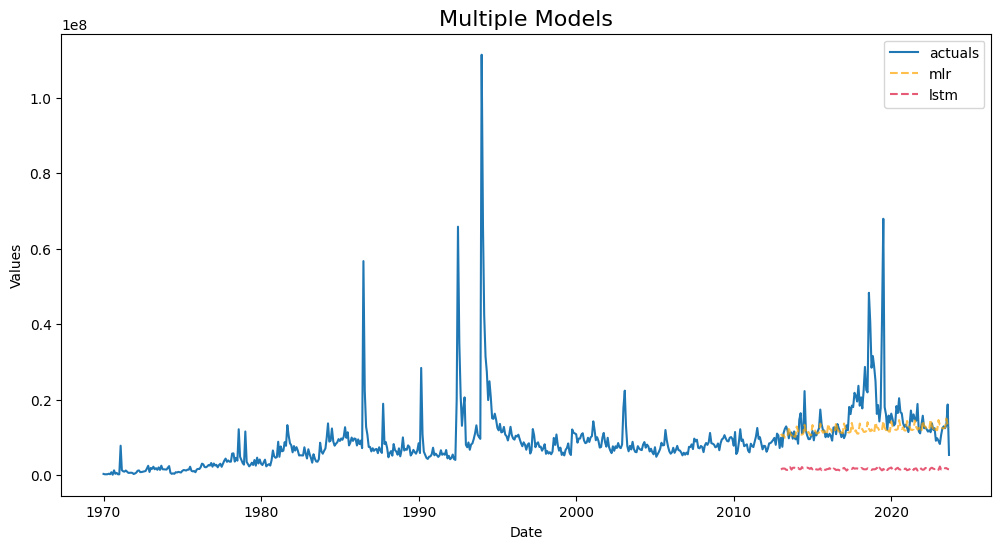

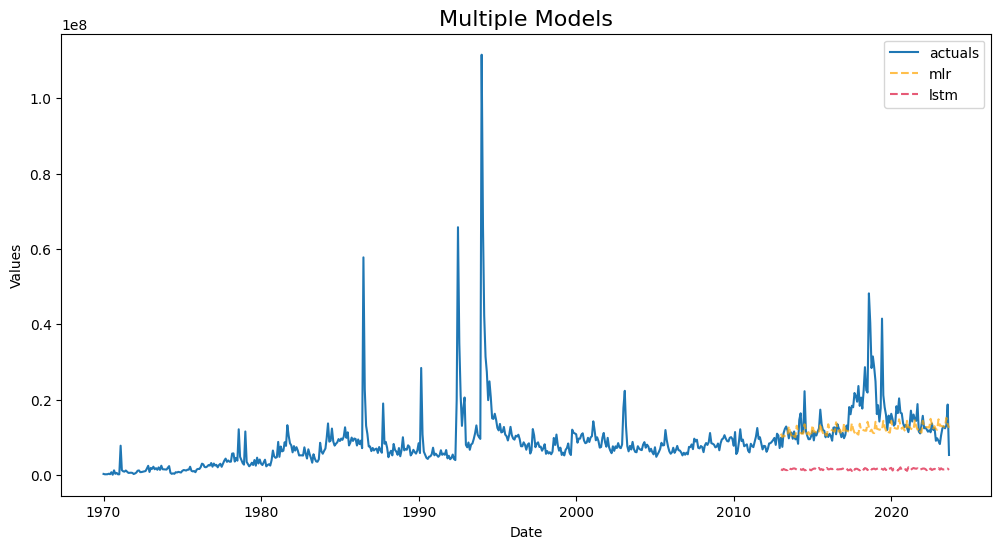

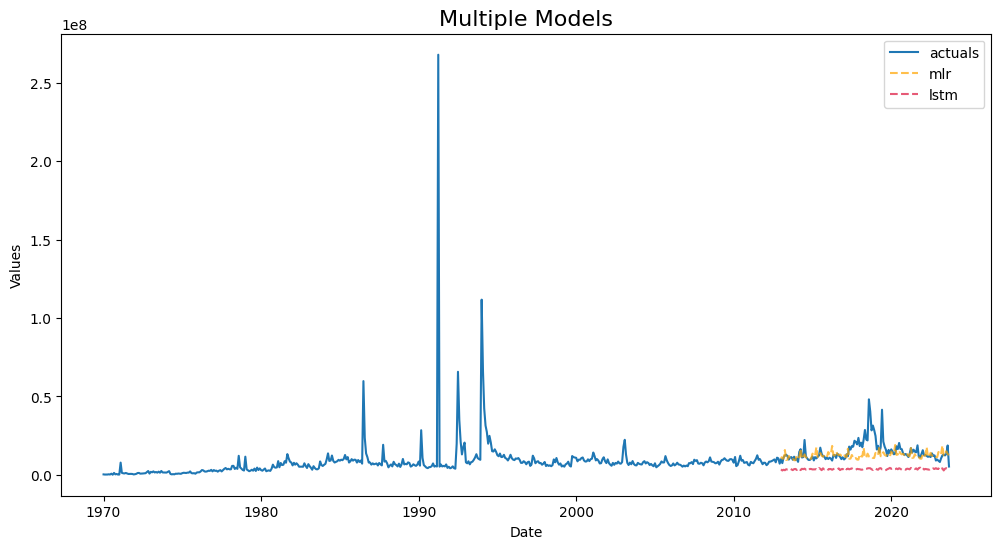

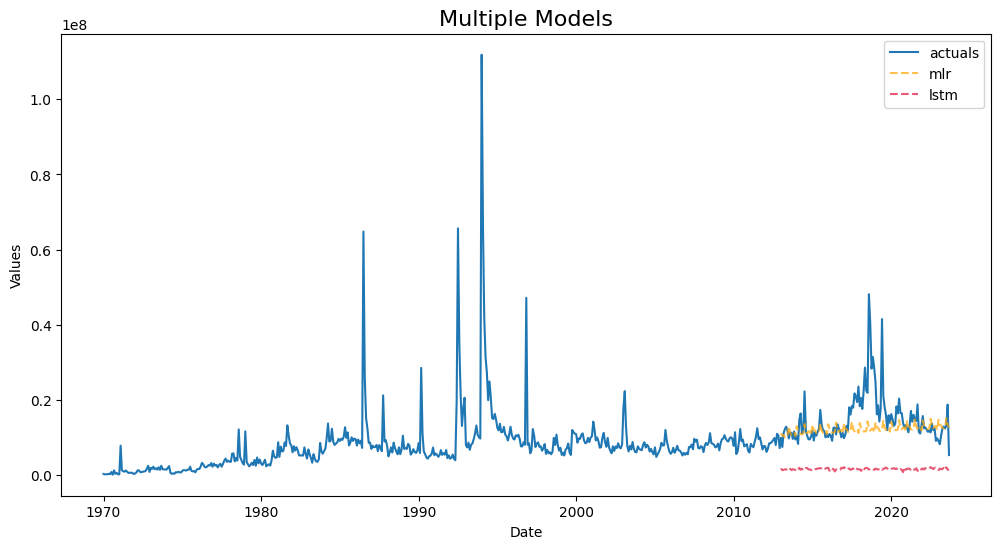

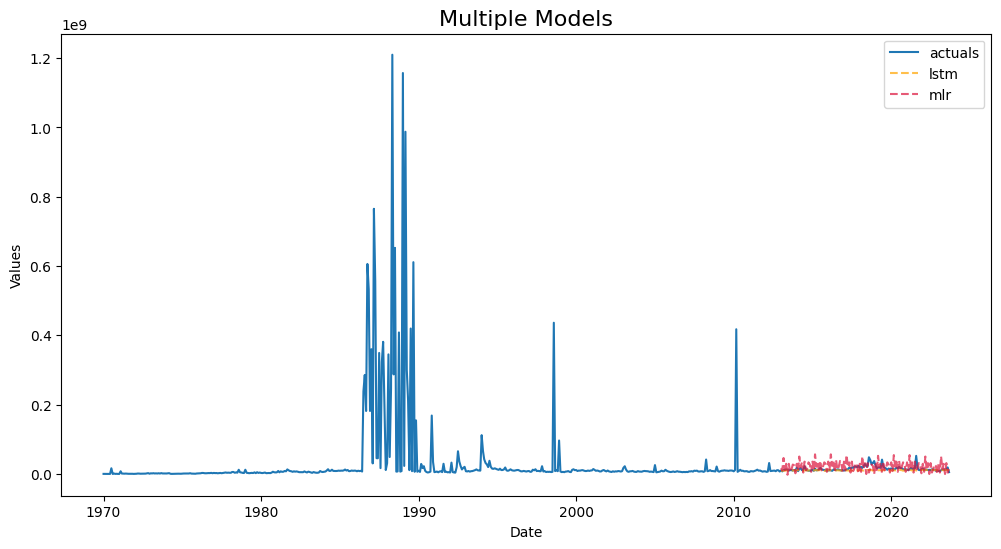

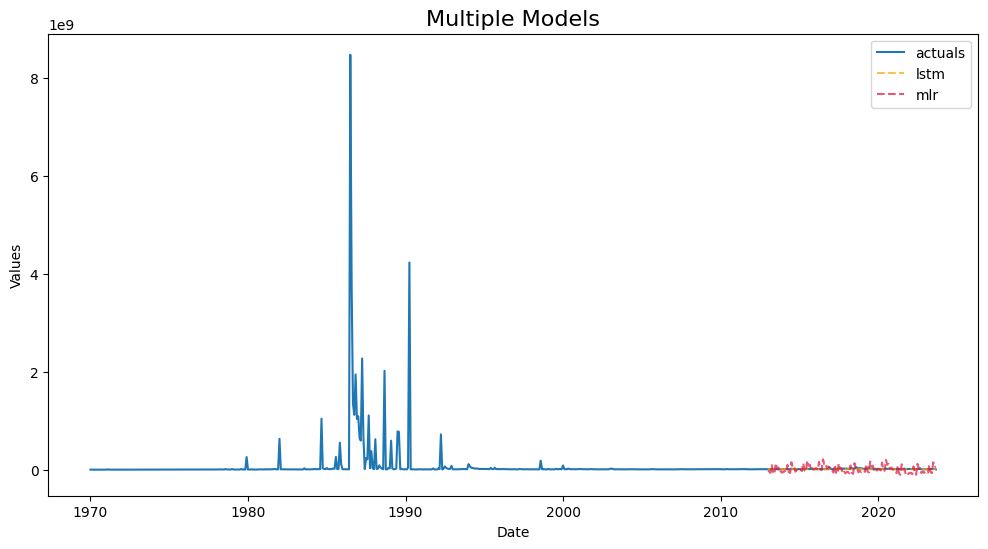

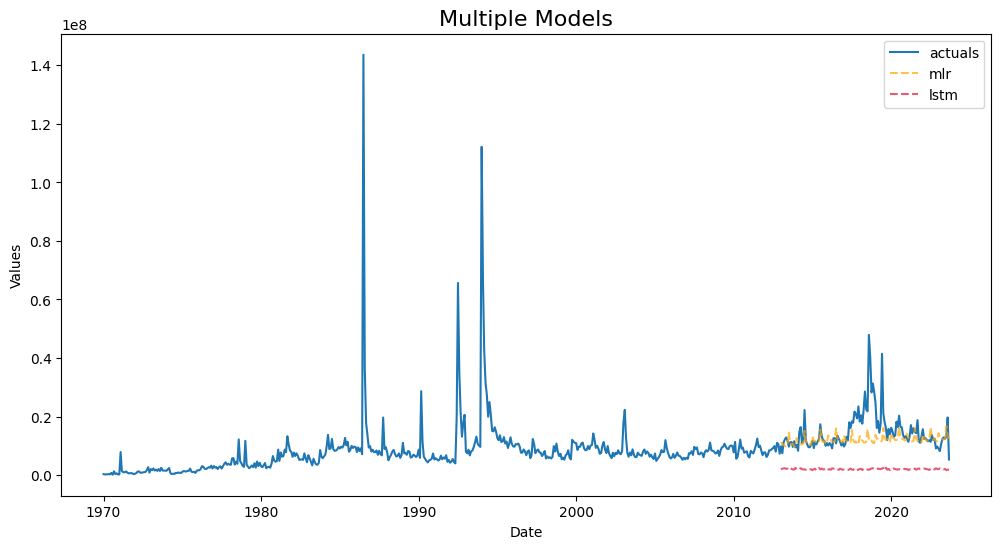

In [54]:
plot_counter = 0
for k, f in list(forecasters_2.items())[:10]:
  f.set_test_length(.2)
  f.generate_future_dates(60)
  f.add_ar_terms(6)
  f.add_seasonal_regressors('month', dummy=True)
  f.add_seasonal_regressors('year')
  f.add_time_trend()
  f.set_estimator('mlr')
  f.manual_forecast()
  f.plot_test_set(order_by='TestSetMAE',models=['lstm', 'mlr'], ci = True)
  plt.title('Multiple Models',size=16)
  plt.show()

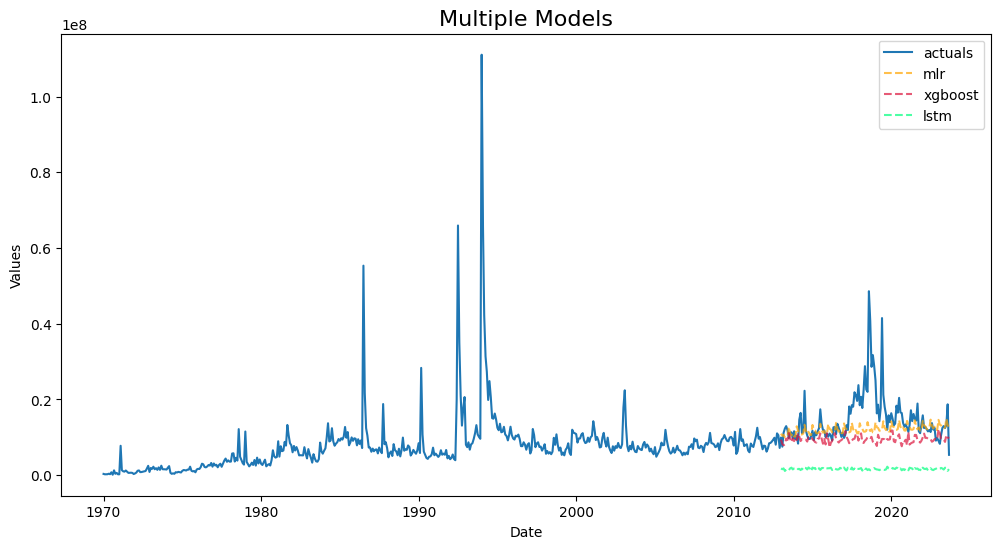

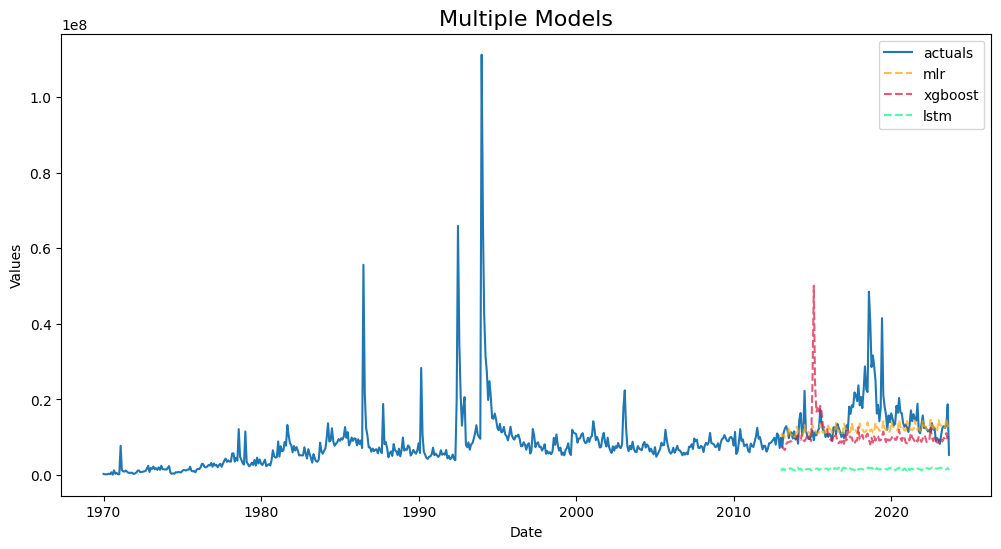

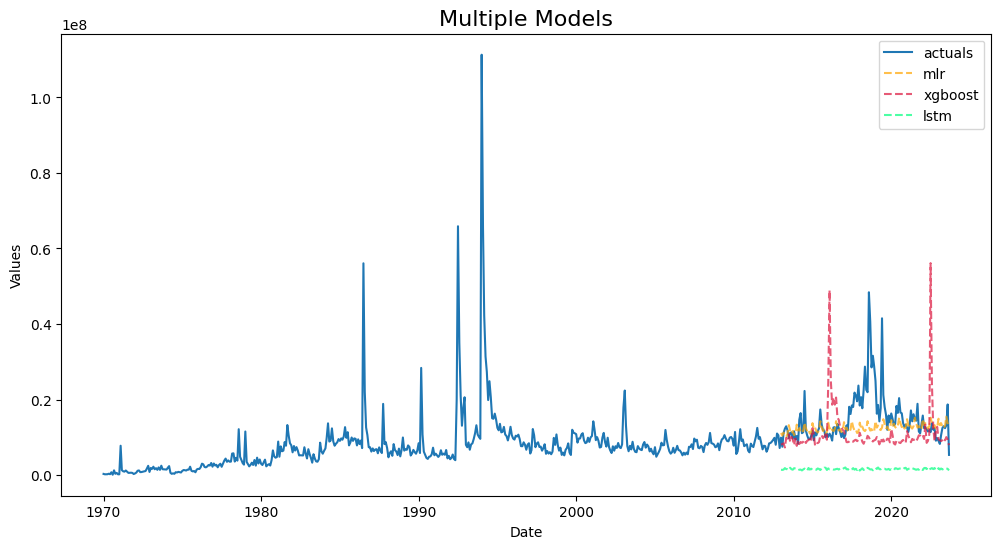

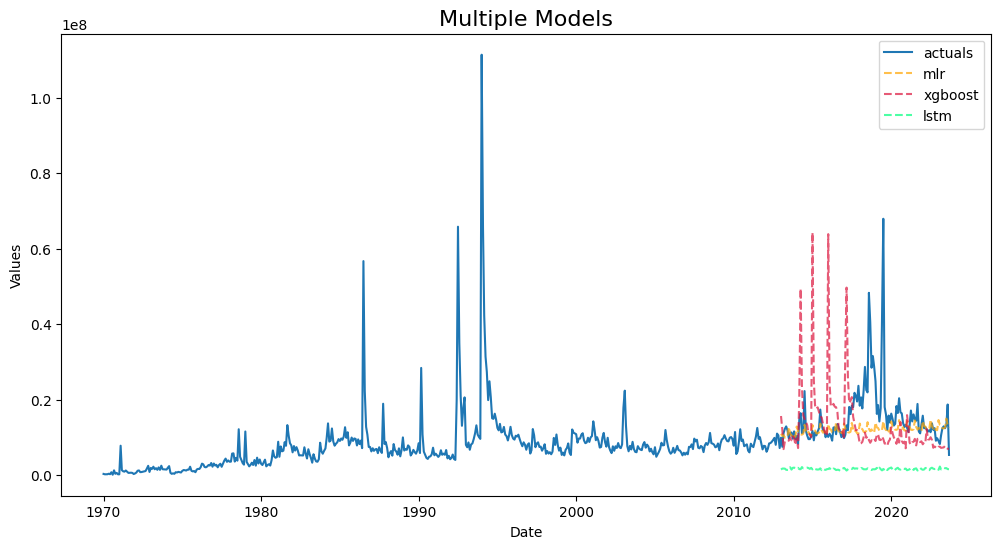

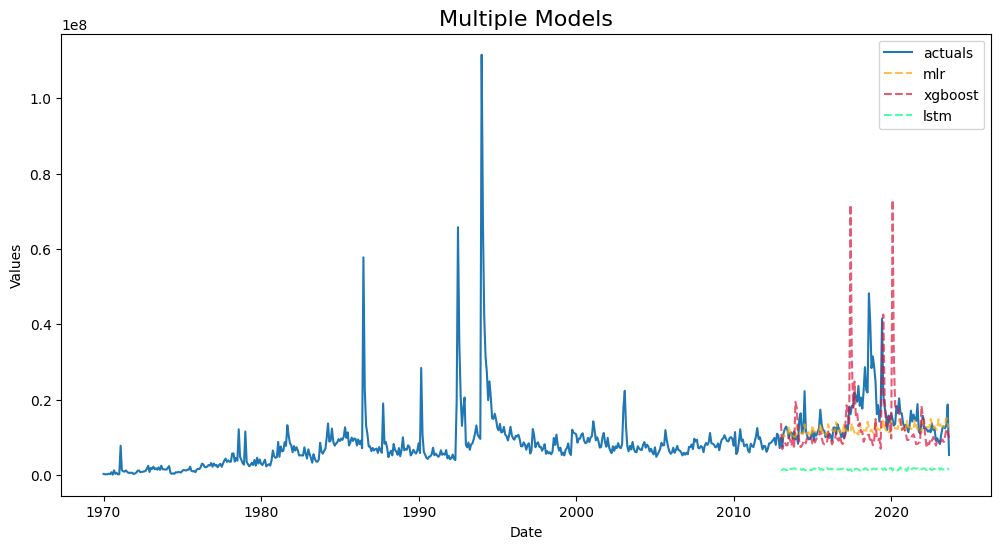

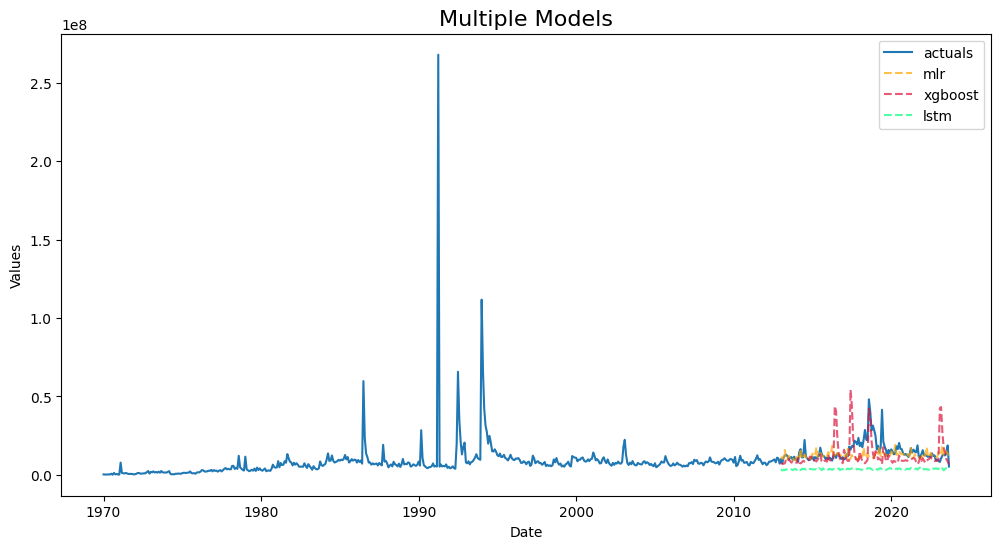

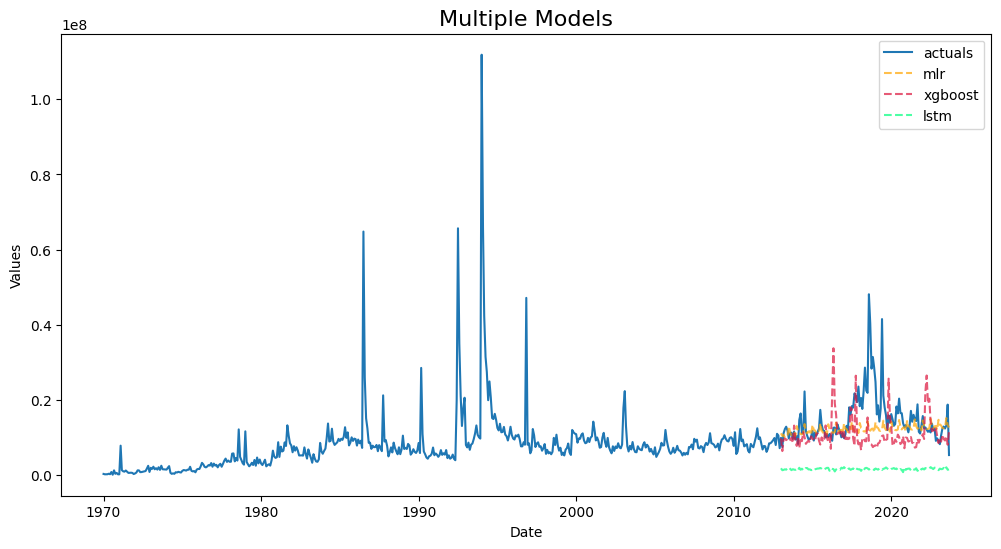

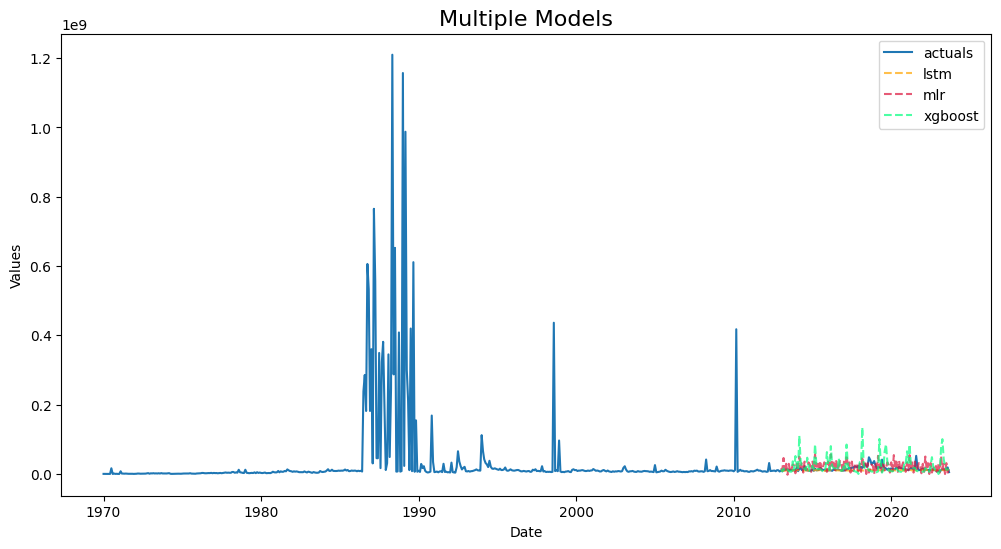

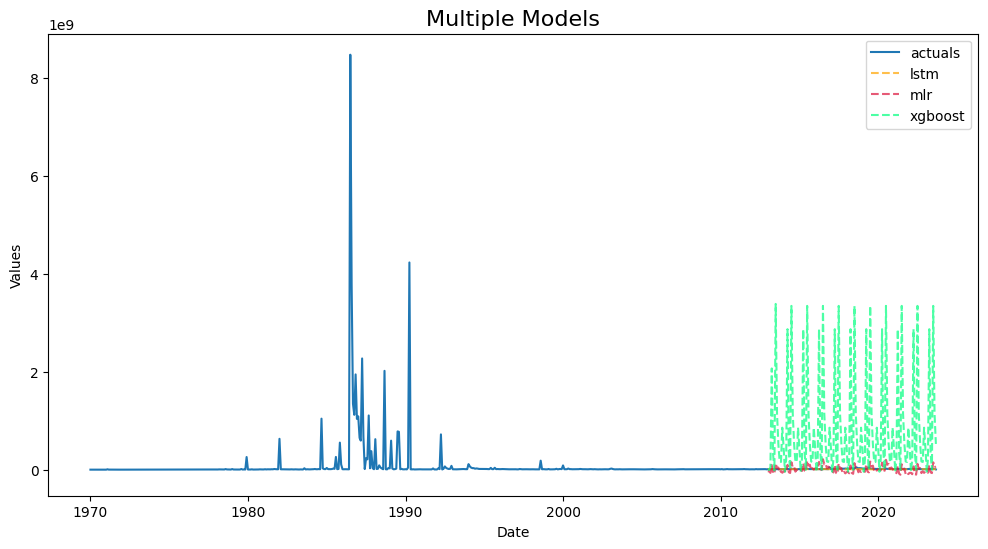

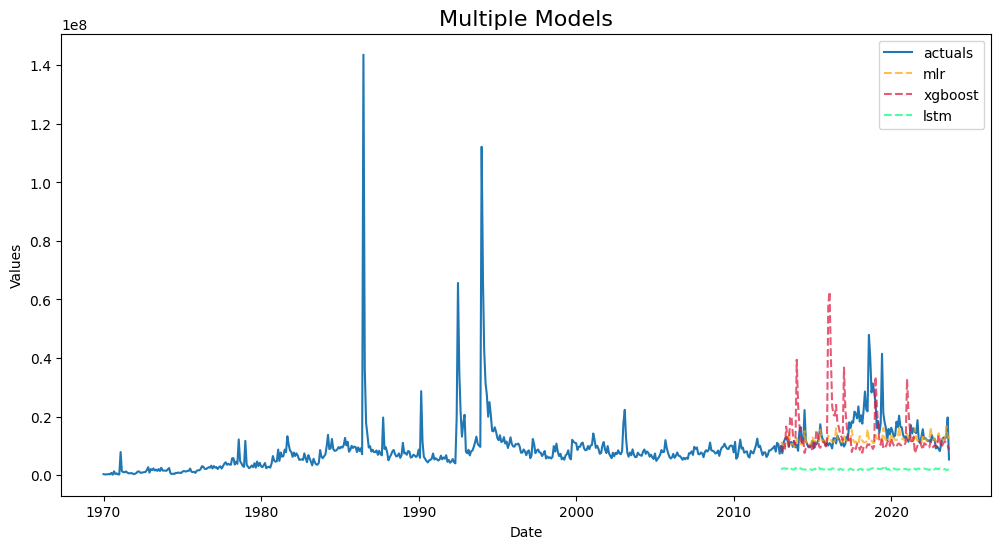

In [55]:
plot_counter = 0
for k, f in list(forecasters_2.items())[:10]:
  f.set_test_length(.2)
  f.generate_future_dates(60)
  f.add_ar_terms(6)
  f.add_seasonal_regressors('month', dummy=True)
  f.add_seasonal_regressors('year')
  f.add_time_trend()
  f.set_estimator('xgboost')
  f.manual_forecast()
  f.plot_test_set(order_by='TestSetMAPE',models=['xgboost','lstm', 'mlr'])
  plt.title('Multiple Models',size=16)
  plt.show()

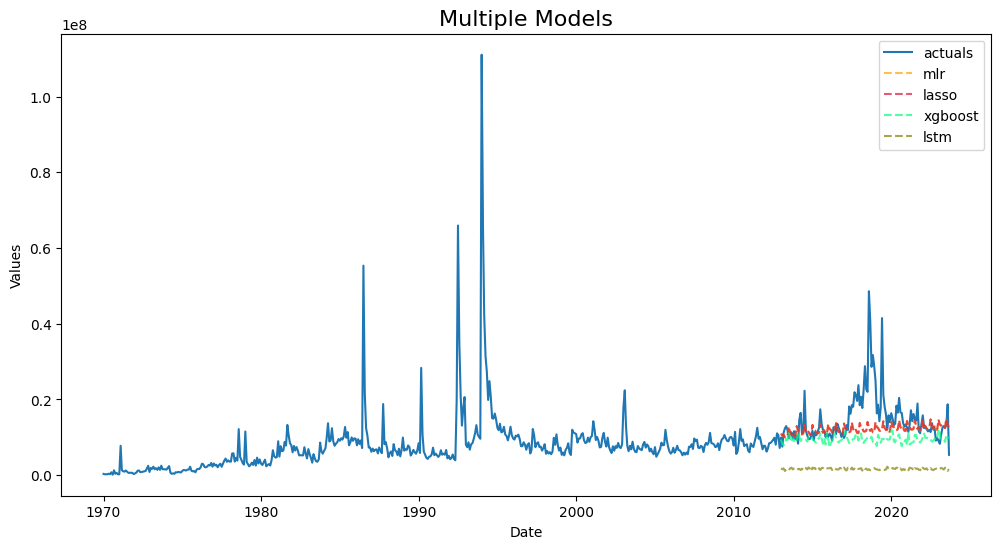

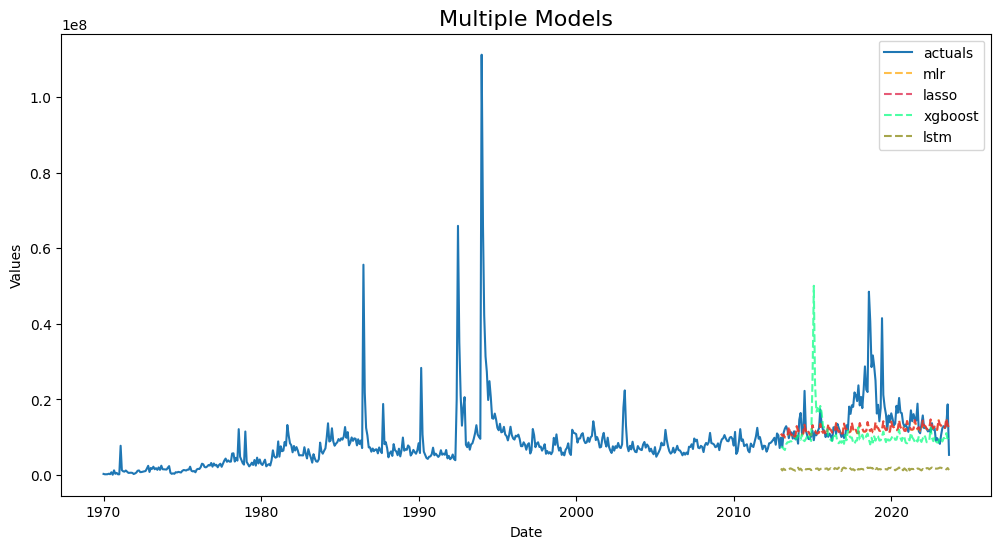

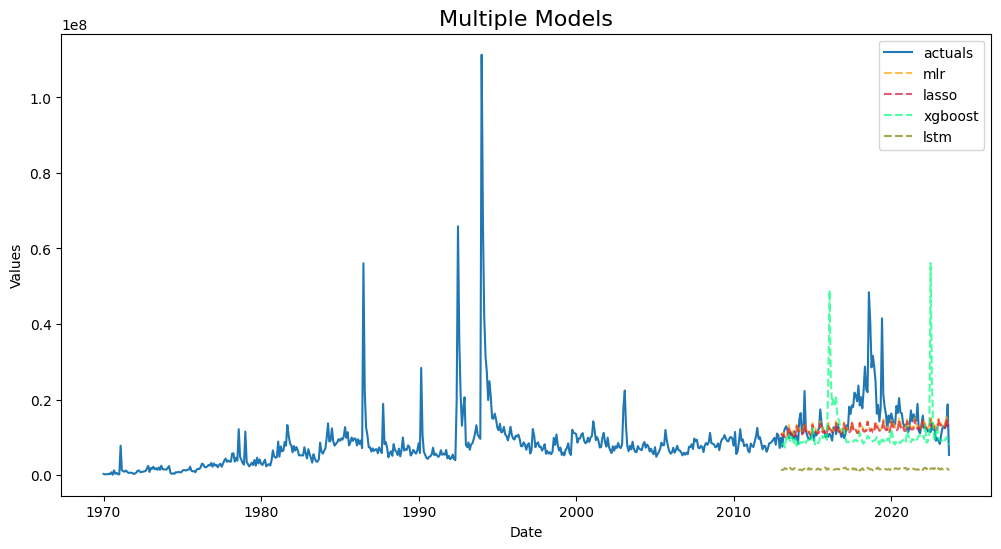

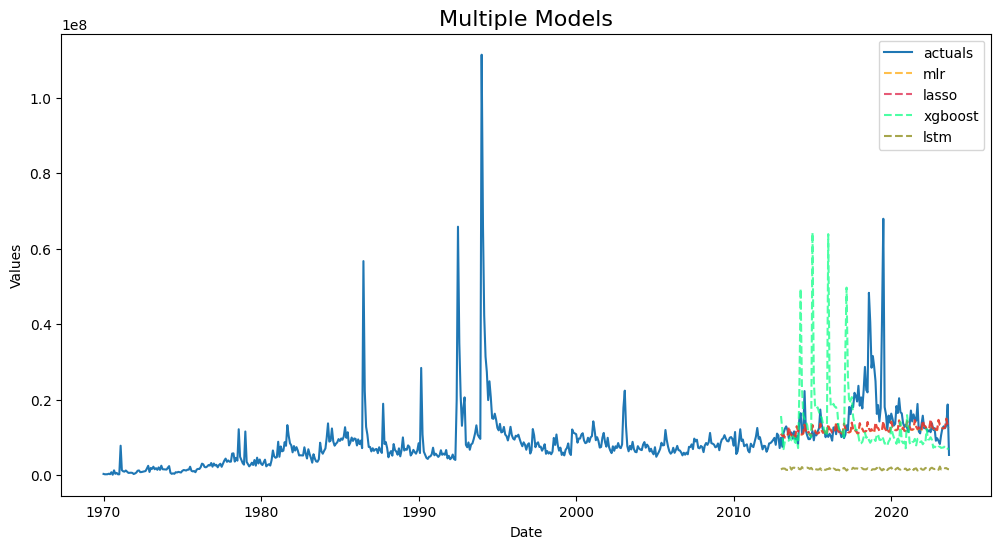

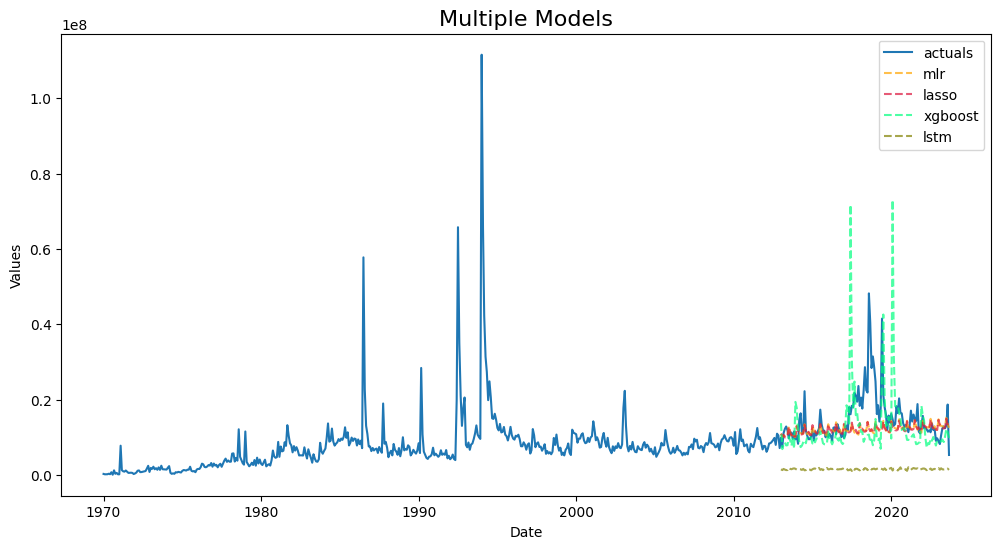

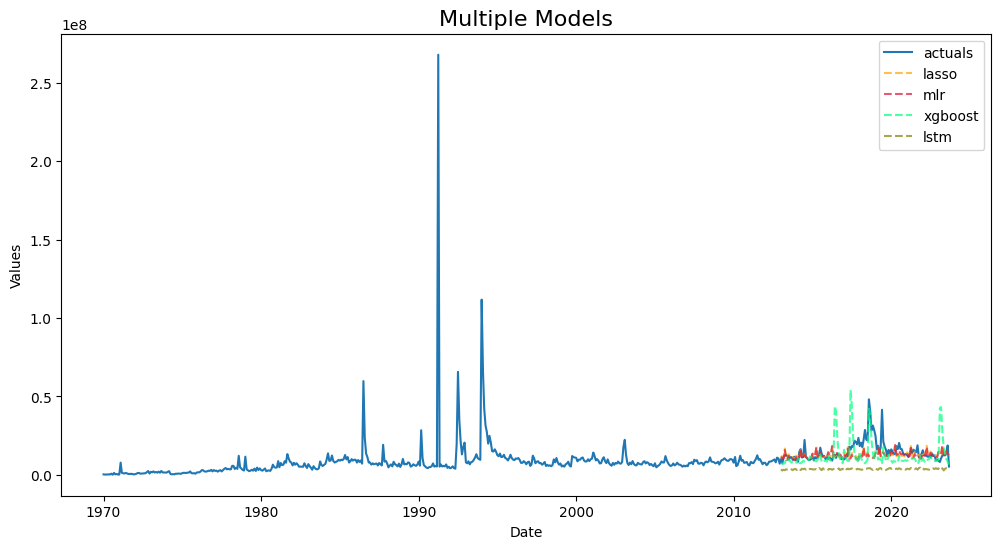

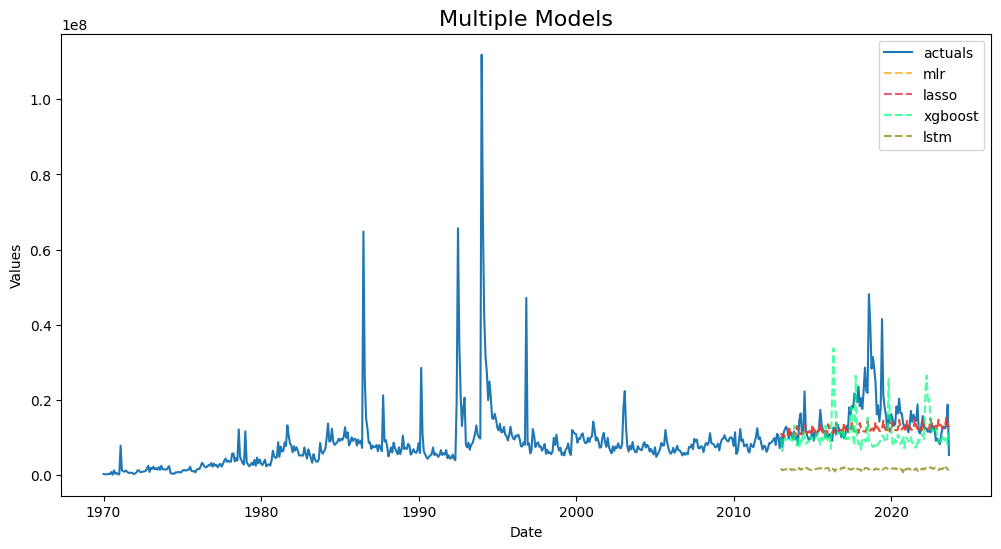

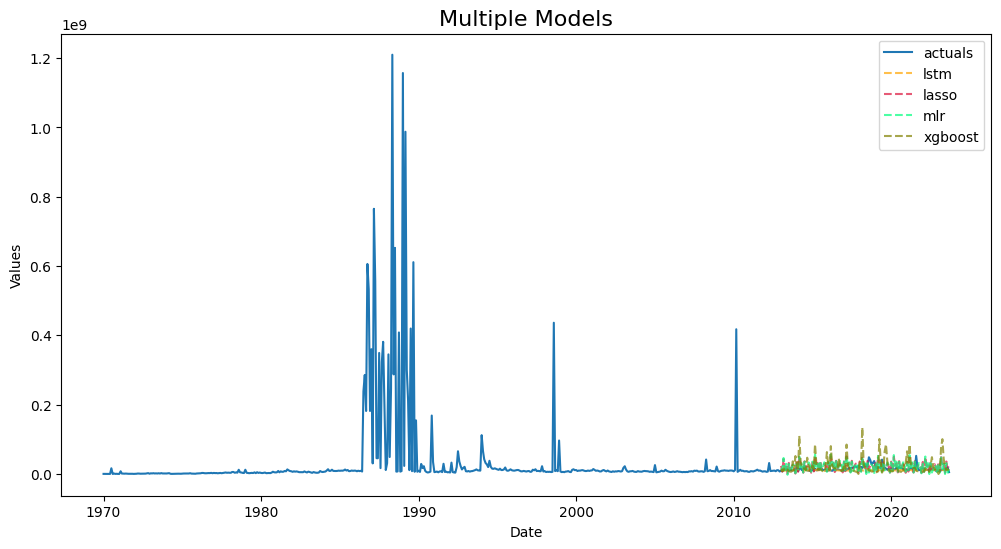

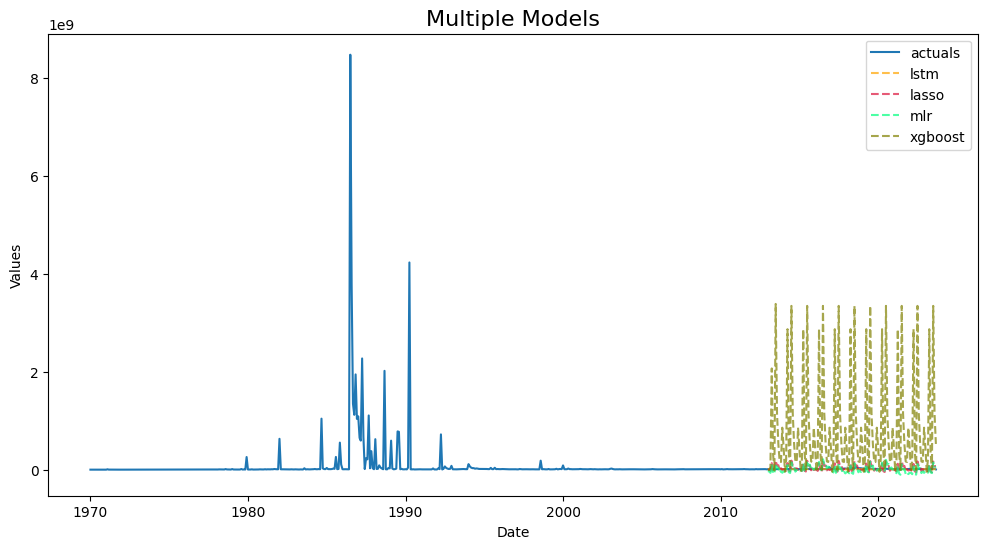

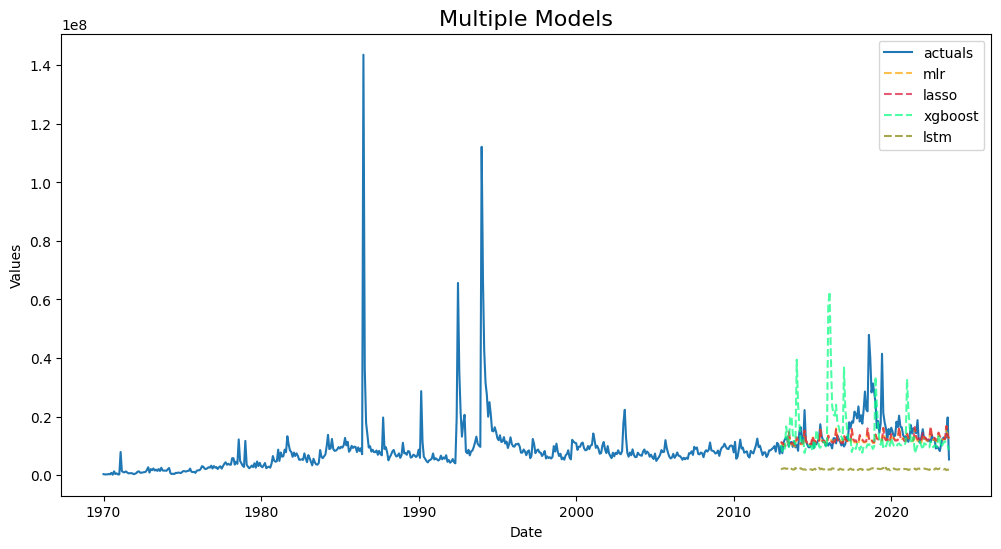

In [56]:
plot_counter = 0
for k, f in list(forecasters_2.items())[:10]:
  f.set_test_length(.2)
  f.generate_future_dates(60)
  f.add_ar_terms(6)
  f.add_seasonal_regressors('month', dummy=True)
  f.add_seasonal_regressors('year')
  f.add_time_trend()
  f.set_estimator('lasso')
  f.manual_forecast()
  f.set_metrics(['mape', 'mse', 'rmse', 'mae'])
  f.export(
      to_excel = True,
      determine_best_by = 'TestSetMAPE',
      excel_name = f'final_time_series_stationary{k}.xlsx'
  )
  f.plot_test_set(order_by='TestSetMAPE',models=['lstm', 'mlr', 'xgboost', 'lasso'])
  plt.title('Multiple Models',size=16)
  plt.show()
